In [ ]:
#| default_exp experiments

In [ ]:
#| export

from __future__ import annotations


In [ ]:
#| hide
# %reload_ext autoreload
# %autoreload 0


# install (Colab)

In [ ]:
# try: 
#     import fastcore as FC
# except ImportError: 
#     !pip install -q fastcore
# try:
#     import rich
# except ImportError:
#     !pip install -q rich


In [ ]:
# !pip uninstall Pillow

In [ ]:
# !pip install "pillow<10.1.0,>=8.3.2"

> **Note: we're using the `testbed` branch of PanelCleaner.**

In [ ]:
# !pip install -q git+https://github.com/civvic/PanelCleaner.git@testbed-colab

# PanelCleaner Testbed
> An PanelCleaner space to explore, play, colaborate and experiment with ML/DL techniques.


# Prologue

In [ ]:
#| export
import contextlib
import dataclasses
import datetime
import difflib
import functools
import json
import os
import shutil
import tempfile
from collections import defaultdict
from enum import Enum
from pathlib import Path
from typing import Any
from typing import Callable
from typing import cast
from typing import Mapping
from typing import TypeAlias

import fastcore.all as FC
import ipywidgets as W
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pcleaner.config as cfg
import pcleaner.ctd_interface as ctm
import pcleaner.image_ops as ops
import pcleaner.ocr.ocr as ocr
import pcleaner.structures as st
import torch
import traitlets as T
from IPython.display import clear_output
from IPython.display import display
from IPython.display import HTML
from loguru import logger
from pcleaner.ocr.ocr_tesseract import TesseractOcr
from PIL import Image
from PIL import ImageFilter
from rich.console import Console
from tqdm.notebook import tqdm

from testbed.helpers import *
from testbed.ocr_metric import *
from testbed.visor import ContextVisor
from testbed.visor import Spinner
from testbed.web_server import WebServer
from testbed.web_server import setup_ngrok
from testbed.web_server import WebServerBottle


In [ ]:
import copy
import re
from contextlib import ExitStack
from typing import Protocol

import fastcore.xtras  # patch `Path` with some utils (like `ls()` to list folder contents)
import pcleaner.cli_utils as cli
import pcleaner.preprocessor as pp
import pytesseract
import rich
from fastcore.test import *  # type: ignore


# Helpers

In [ ]:
# pretty print by default
# %load_ext rich

In [ ]:
#| exporti
console = Console(width=104, tab_size=4, force_jupyter=True)
cprint = console.print


## USE_PIL

The experiments can generate hundreds of images, and maintaining the **PIL** images in memory is not efficient. All the generated images are cached and visualized on demand through a URL pointing to the local cache. This approach prevents the kernel from being overloaded with **PIL** images, with the front-end responsible for fetching the image and the backend web server (not the kernel) for serving the image in another process. This method is quick and efficient. As an added bonus, the saved notebook remains lean and fit; it doesn't store the Base64 versions of all the output cell images.

Unfortunately, this approach does not work as is in **Colab**. Google Colab runs on an older Ubuntu 18.04 VM, so all the usual networking challenges with Docker, or whatever VMs Google is using, apply. Google also goes to great lengths to avoid exposing its internal architecture. We have two options:
- Let the Jupyter kernel serve the images itself, which is slow and memory-consuming.
- Use a tunnel to map localhost (server) to whatever IP and port the front-end (the browser you're currently using) is running on. We can use **ngrok** for this, but *ngrok* is a commercial service that has been abused and now requires confirmation the first time the tunnel connects, which can be inconvenient for the user. It also requires the user to open a free account and obtain an auth token.

You choose.

If the notebook is running in Colab and ngrok has been successfully installed and the tunnel has been created, the default setting is USE_PIL=False. You can set the environment variable USE_PIL=True to force the use of PIL images, but note that in certain circumstances, Colab will complain because the free tiers are usually memory constrained.


In [ ]:
#| exporti

os.environ['USE_PIL'] = 'False'
os.environ['USE_TUNNEL'] = 'False'
SERVER = None


## Tesseract setup

Get current version of Tesseract

In [ ]:
out = !tesseract --version  # type: ignore
cprint(out)
if 'tesseract 5.' not in out[0]:
    if 'tesseractd 4.' in out[0]:
        cprint('Old Tesseract 4.x is installed. You should uninstall it and install Tesseract 5.x')
    else:
        cprint('You should install Tesseract 5.x')


[
    'tesseract 5.3.4',
    ' leptonica-1.84.1',
    '  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 3.0.0) : libpng 1.6.43 : libtiff 4.6.0 : zlib 1.2.11 : 
libwebp 1.4.0 : libopenjp2 2.5.2',
    ' Found NEON',
    ' Found libarchive 3.7.2 zlib/1.2.11 liblzma/5.4.6 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.6',
    ' Found libcurl/8.6.0 SecureTransport (LibreSSL/3.3.6) zlib/1.2.12 nghttp2/1.61.0'
]

> **NOTE: in below cells, when you encounter lines starting with the exclamation mark `!` (`bang`), uncoment them if you want to excute the shell commands**


### Remove Tesseract installation
> I you have the old 4.x version, you should consider removing the installation with the following commands.


#### Mac (TBD)

#### WIndows (TBD)

#### Ubuntu

In [ ]:
# !sudo apt-get remove tesseract-ocr


### Tesseract installation

#### Mac (TBD)

#### WIndows (TBD)

#### Ubuntu

The **5.x** release series is available in the [another PPA](https://launchpad.net/~alex-p/+archive/ubuntu/tesseract-ocr5) for Ubuntu **18.04**, **20.04**, and **22.04**.


In [ ]:
# !sudo add-apt-repository -y ppa:alex-p/tesseract-ocr5

refresh system package cache in case you’re still running old Ubuntu 18.04

In [ ]:
# !sudo apt update

install the software engine

In [ ]:
# !sudo apt install -y tesseract-ocr

and check version:

In [ ]:
out = !tesseract --version  # type: ignore
cprint(out)

[
    'tesseract 5.3.4',
    ' leptonica-1.84.1',
    '  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 3.0.0) : libpng 1.6.43 : libtiff 4.6.0 : zlib 1.2.11 : 
libwebp 1.4.0 : libopenjp2 2.5.2',
    ' Found NEON',
    ' Found libarchive 3.7.2 zlib/1.2.11 liblzma/5.4.6 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.6',
    ' Found libcurl/8.6.0 SecureTransport (LibreSSL/3.3.6) zlib/1.2.12 nghttp2/1.61.0'
]

### Install Tesseract languages

In [ ]:
out = !tesseract --list-langs  # type: ignore
tessdata = Path(out[0].split('"')[1])
cprint(f"tessdata path: {tessdata}")
cprint("Installed languages:", [', '.join(sub) for sub in [out[i:i + 15] for i in range(1, len(out), 15)]])

tessdata path: /opt/homebrew/share/tessdata

Installed languages:
[
    'afr, amh, ara, asm, aze, aze_cyrl, bel, ben, bod, bos, bre, bul, cat, ceb, ces',
    'chi_sim, chi_sim_vert, chi_tra, chi_tra_vert, chr, cos, cym, dan, deu, div, dzo, ell, eng, enm, 
epo',
    'equ, est, eus, fao, fas, fil, fin, fra, frk, frm, fry, gla, gle, glg, grc',
    'guj, hat, heb, hin, hrv, hun, hye, iku, ind, isl, ita, ita_old, jav, jpn, jpn_vert',
    'kan, kat, kat_old, kaz, khm, kir, kmr, kor, kor_vert, lao, lat, lav, lit, ltz, mal',
    'mar, mkd, mlt, mon, mri, msa, mya, nep, nld, nor, oci, ori, osd, pan, pol',
    'por, pus, que, ron, rus, san, script/Arabic, script/Armenian, script/Bengali, 
script/Canadian_Aboriginal, script/Cherokee, script/Cyrillic, script/Devanagari, script/Ethiopic, 
script/Fraktur',
    'script/Georgian, script/Greek, script/Gujarati, script/Gurmukhi, script/HanS, script/HanS_vert, 
script/HanT, script/HanT_vert, script/Hangul, script/Hangul_vert, script/Hebrew, script/Japanese, 
script/Japanese_vert, script/Kannada, script/Khmer',
    'script/Lao, script/Latin, script/Malayalam, script/Myanmar, script/Oriya, script/Sinhala, 
script/Syriac, script/Tamil, script/Telugu, script/Thaana, script/Thai, script/Tibetan, 
script/Vietnamese, sin, slk',
    'slv, snd, snum, spa, spa_old, sqi, srp, srp_latn, sun, swa, swe, syr, tam, tat, tel',
    'tgk, tha, tir, ton, tur, uig, ukr, urd, uzb, uzb_cyrl, vie, yid, yor'
]

####  Install **best** languages and **jpn_ver** Tesseract lang
> Much better results than default langs and `jpn` language model.


Download from [tessdata_best](https://github.com/tesseract-ocr/tessdata_best).  
Donwload from [here](https://groups.google.com/g/tesseract-ocr/c/FwjSZzoVgeg/m/u-zyFYQiBgAJ) a model trained for vertical Japanese text as found in manga.

See [here](https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html) the languages codes.

> Note: I've not play much with `jpn` or `jpn_vert`, `manag-ocr` is surely a much better fit, but it can be educational to compare.

Uncomment and excute to download the best language models:


In [ ]:
# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/osd.traineddata
# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/eng.traineddata
# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/jpn.traineddata

# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/jpn_vert.traineddata
# or
# !wget -O jpn_vert.traineddata https://github.com/zodiac3539/jpn_vert/blob/master/jpn_ver5.traineddata

# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/spa.traineddata
# !wget https://raw.githubusercontent.com/tesseract-ocr/tessdata_best/main/fra.traineddata

Copy downloaded models to tessdata folder (double check that `tessdata` variable points to the right folder):


In [ ]:
cprint(f"tessdata path: {tessdata}")

tessdata path: /opt/homebrew/share/tessdata

In [ ]:
# !sudo mv *.traineddata $tessdata

and remove the downloaded models:


In [ ]:
# !rm *.traineddata

Check installed languages


In [ ]:
cprint(list(filter(lambda x: re.match(r'eng|jpn|jpn_vert|fra|spa', x.name), tessdata.ls())))  # type: ignore
# cprint(pytesseract.get_languages())


[
    Path('/opt/homebrew/share/tessdata/spa.traineddata'),
    Path('/opt/homebrew/share/tessdata/eng.traineddata'),
    Path('/opt/homebrew/share/tessdata/jpn_vert.traineddata'),
    Path('/opt/homebrew/share/tessdata/spa_old.traineddata'),
    Path('/opt/homebrew/share/tessdata/fra.traineddata'),
    Path('/opt/homebrew/share/tessdata/jpn.traineddata')
]

## Ground truth

In [ ]:
#| export

def ground_truth_path_old(page_data: st.PageData):
    path = Path(page_data.original_path)
    return path.with_stem(path.stem + '_gt').with_suffix('.txt')


def read_ground_truth_old(page_data: st.PageData, root_dir: Path):
    gts_path = root_dir / ground_truth_path_old(page_data)
    if gts_path.exists():
        gts = gts_path.read_text(encoding="utf-8").splitlines()
    else:
        gts = ["" for _ in range(len(page_data.boxes))]
    return gts


def ground_truth_path(page_data: st.PageData):
    path = Path(page_data.original_path)
    return path.with_stem(path.stem + '_gt').with_suffix('.json')


def read_ground_truth(page_data: st.PageData, root_dir: Path) -> dict[str, list[str]]:
    gts_path = root_dir / ground_truth_path(page_data)
    empty = ["" for _ in range(len(page_data.boxes))]
    if gts_path.exists():
        try:
            with open(gts_path, 'r') as f:
                data = json.load(f)
                if 'all-caps' not in data:
                    data['all-caps'] = empty
                if 'capitalized' not in data:
                    data['capitalized'] = empty.copy()
                return data
        except Exception as e:
            logger.error(f"Error loading {gts_path}: {e}")
    gts = {'all-caps': empty,
            'capitalized': empty.copy()}
    return gts


def save_ground_truth(gts: dict[str, list[str]], page_data: st.PageData, root_dir: Path):
    fp = root_dir / ground_truth_path(page_data)
    with open(fp, 'w') as f:
        json.dump(gts, f, indent=2)
    return fp


## Cropping

In [ ]:
#| export

def dilate_by_fractional_pixel(image, dilation_fraction, filter_base_size=3):
    """
    Dilates an image by a specified fractional pixel amount. The function calculates 
    the necessary scaling factor and filter size based on the desired dilation fraction.

    :param image: A PIL Image object (1-bit mode).
    :param dilation_fraction: The desired fractional pixel amount for dilation (e.g., 0.2).
    :param filter_base_size: The base size of the dilation filter to apply on the scaled image.
                             This size is adjusted based on the scaling factor to achieve the
                             desired dilation effect.
    :return: A PIL Image object after dilation, converted back to grayscale.
    """
    from PIL.Image import Resampling
    # Calculate the scale factor based on the desired dilation fraction
    scale_factor = int(1 / dilation_fraction)
    
    # Adjust the filter size based on the scale factor
    # This ensures the dilation effect is proportional to the desired fraction
    filter_size = max(1, filter_base_size * scale_factor // 5)

    # Convert the image to grayscale for more nuanced intermediate values
    image_gray = image.convert("L")

    # Resize the image to a larger size using bicubic interpolation
    larger_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    image_resized = image_gray.resize(larger_size, Resampling.BICUBIC)

    # Apply the dilation filter to the resized image
    dilated_image = image_resized.filter(ImageFilter.MaxFilter(filter_size))

    # Resize the image back to its original size using bicubic interpolation
    image_dilated_fractional_pixel = dilated_image.resize(image.size, Resampling.BICUBIC)

    return image_dilated_fractional_pixel


In [ ]:
#| export

def extract_text(image, text_mask, box):
    cropped_image = crop_box(box, image)
    cropped_mask = crop_box(box, text_mask)
    extracted = ops.extract_text(cropped_image, cropped_mask)
    return cropped_image, cropped_mask, extracted


## Lang
> language name to a language code  
> every one has language codes: tesseract, comic-text-detector, earthlings...


In [ ]:
#| exporti

_lang2pcleaner = {'English': st.DetectedLang.ENG, 'Japanese': st.DetectedLang.JA, 'Spanish': st.DetectedLang.ENG,
                    'French':st.DetectedLang.ENG}
# _lang2tesseract = {'English': 'eng', 'Japanese': 'jpn'}
_lang2tesseract = {'English': 'eng', 'Japanese': 'jpn_vert', 'Spanish': 'spa', 'French': 'fra'}


In [ ]:
#| export
def lang2pcleaner(lang: str):
    return _lang2pcleaner[lang]

def lang2tesseract(lang: str):
    return _lang2tesseract[lang]


----
# Experiments helpers

## CropMethod
> Box cropping methods.


In [ ]:
#| export

class CropMethod(Enum):
    INITIAL_BOX = 'Initial box'
    DEFAULT = 'Default'
    DEFAULT_GREY_PAD = 'Default, grey pad'
    PADDED_4 = 'Padded 4px'
    PADDED_8 = 'Padded 8px'
    EXTRACTED_INIT_BOX = 'Extracted, init box'
    PADDED_4_EXTRACTED = 'Padded 4, extracted'
    PADDED_8_EXTRACTED = 'Padded 8, extracted'
    PADDED_8_DILATION_1 = 'Padded 8, dilation 1'
    PAD_8_FRACT_0_5 = 'Pad 8, fract. 0.5'
    PAD_8_FRACT_0_2 = 'Pad 8, fract. 0.2'

    @classmethod
    def __display_names__(cls):
        return dict(
            zip([_.value for _ in cls], 
            cls))


CM = CropMethod

_IMAGE_METHODS = [CM.INITIAL_BOX, CM.DEFAULT, CM.DEFAULT_GREY_PAD, 
                    CM.PADDED_4, CM.PADDED_8]
_EXTRACTED_METHODS = [CM.EXTRACTED_INIT_BOX, CM.PADDED_4_EXTRACTED, 
                        CM.PADDED_8_EXTRACTED, CM.PADDED_8_DILATION_1, 
                        CM.PAD_8_FRACT_0_5, CM.PAD_8_FRACT_0_2]


def crop_by_image(method: CM, 
        box: st.Box, 
        base: Image.Image, 
        preproc: cfg.PreprocessorConfig,
    ):
    image = None
    match method:
        case CM.INITIAL_BOX :
            image = crop_box(box, base)
        case CM.DEFAULT:
            padded2_4 = (
                box.pad(preproc.box_padding_initial, base.size).right_pad(
                            preproc.box_right_padding_initial, base.size))
            image = crop_box(padded2_4, base)
        case CM.DEFAULT_GREY_PAD:
            image = crop_box(box, base)
            image = ops.pad_image(image, 8, fill_color=(128, 128, 128))
        case CM.PADDED_4:
            padded4 = box.pad(4, base.size)
            image = crop_box(padded4, base)
        case CM.PADDED_8:
            padded4 = box.pad(8, base.size)
            image = crop_box(padded4, base)
        case _: pass
    return image


def crop_by_extracted(method: CM, 
        box: st.Box, 
        base: Image.Image, 
        mask: Image.Image,
        cropped_image_path: Path,
        cropped_mask_path: Path,
        dilated: dict[float, Image.Image]
    ):
    cropped_image, cropped_mask, image = None, None, None
    if method in _EXTRACTED_METHODS:
        if not cropped_image_path.exists() or not cropped_mask_path.exists():
            match method:
                case CM.EXTRACTED_INIT_BOX:
                    cropped_image, cropped_mask, image = extract_text(base, mask, box)
                case CM.PADDED_4_EXTRACTED:
                    padded4 = box.pad(4, base.size)
                    cropped_image, cropped_mask, image = extract_text(base, mask, padded4)
                case CM.PADDED_8_EXTRACTED:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(base, mask, padded8)
                case CM.PADDED_8_DILATION_1:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[1], padded8)
                case CM.PAD_8_FRACT_0_5:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[0.5], padded8)
                case CM.PAD_8_FRACT_0_2:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[0.2], padded8)
                case _: pass

    return image, cropped_image, cropped_mask



## ExperimentContext
> Utility class to maintain shared state across all experiments.


In [ ]:
#| export

SubjIdT: TypeAlias = int
RunIdT: TypeAlias = str
SubjSpecT: TypeAlias = SubjIdT | str | Path


class ExperimentSubject:
    exp: ExperimentContext
    idx: SubjIdT

    def setup(self, exp: ExperimentContext, idx: Any, *args, **kwargs): 
        self.exp = exp
        self.idx = cast(SubjIdT, exp.normalize_idx(idx))
        return self

    def __new__(cls, exp: ExperimentContext, idx: Any, *args, **kwargs):
        idx = exp.normalize_idx(idx)
        self = exp.subject_context(idx)
        if self is None:
            self = super().__new__(cls)
            self = exp.setup_subject_context(idx, self, *args, **kwargs)
            if self is None:
                raise ValueError(f"Can't create new subject with idx: {idx}: out of range")
        return self


class Result:
    subject_ctx: ExperimentSubject

class ExperimentRun:
    "A set of experiment results obtained with the same parameters."
    exp: ExperimentContext
    name: RunIdT
    dt: datetime.datetime

    def setup(self, exp: ExperimentContext, name: RunIdT, *args, **kwargs): 
        self.exp = exp
        self.name = name
        return self

    @classmethod
    def setup_run_name(cls, name: RunIdT, dt: datetime.datetime):
        return f"{name}_{dt.strftime('%Y%m%d-%H%M%S')}"

    def setup_run(self, args, **kwargs):
        pass
    def before_result(self, *args, **kwargs):
        pass
    def after_result(self, result: Result, *args, **kwargs):
        pass
    
    def __new__(cls, exp: ExperimentContext, name: RunIdT, *args, **kwargs):
        self = exp.experiment_run(name)
        if self is None:
            self = super().__new__(cls)
            self = exp.setup_experiment_run(name, self, *args, **kwargs)
        return self


class ExperimentContext(T.HasTraits):
    "Class to maintain shared state across all file-based experiments within the experiment domain."
    name: str
    _results: dict[RunIdT, dict[SubjIdT, Any]]

    _dirty = T.Bool(default_value=False)

    CACHE_DIR_NAME: str = 'cache'
    SOURCE_DIR_NAME: str = 'source'
    EXP_DIR: Path = Path("../experiment")

    subject_cls: Callable[..., ExperimentSubject]
    def subject_factory(self) -> Callable[..., ExperimentSubject]: return type(self).subject_cls

    def normalize_idx(self, idx: SubjSpecT) -> SubjIdT | None:
        nidx = None
        if isinstance(idx, int) and idx < self.subject_count:
            nidx = idx
        elif isinstance(idx, str):
            try:
                nidx = [_.name for _ in self._paths].index(idx)
            except Exception:
                pass
        elif isinstance(idx, Path):
            if idx in self._paths:
                nidx = self._paths.index(idx)
        return nidx
    
    def path_from_idx(self, idx: SubjSpecT):
        "Relative path to the subject with the given index."
        _idx = self.normalize_idx(idx)
        if _idx is None:
            raise ValueError(f"{_idx} not found in context.")
        path = Path(self._paths[_idx])
        if not path.resolve().exists():
            raise ValueError(f"{path} not found in context.")
        return path
    
    @property
    def subject_count(self): return len(self._paths)

    @property
    def run_names(self):
        return list(self._exp_runs.keys())

    @property
    def root_dir(self): return self._root
    # Relative paths to `root_dir`
    @property
    def cache_dir(self): return Path(self.CACHE_DIR_NAME)
    @property
    def source_dir(self): return Path(self.SOURCE_DIR_NAME)
    @functools.lru_cache()
    def _subject_cache_dir(self, idx: SubjIdT):
        path = self.path_from_idx(idx)
        subject_cache_dir = self.cache_dir / path.stem
        self.final(subject_cache_dir).mkdir(parents=True, exist_ok=True)
        return subject_cache_dir
    def subject_cache_dir(self, idx: SubjSpecT):
        "Folder to cache and save subject results. Create if needed."
        return self._subject_cache_dir(idx)
    def final(self, path: Path | str): 
        """`path` relative to the root of the experiment.
        If `path` is absolute, it must be in the experiment directory.
        """
        if isinstance(path, str):
            path = Path(path)
        if path.is_absolute():
            try:
                path = path.relative_to(self.root_dir.resolve())
            except Exception:
                return Path('_not_found_/'+path.name)
        return self.root_dir / path
    
    def empty_cache(self, idx: SubjIdT | None = None):
        if idx is None:
            cache_dir = self.final(self.cache_dir)
            shutil.rmtree(cache_dir, ignore_errors=True)
            cache_dir.mkdir(parents=True, exist_ok=True)
        else:
            subject_cache_dir = self.final(self.subject_cache_dir(idx))
            shutil.rmtree(subject_cache_dir, ignore_errors=True)
            subject_cache_dir.mkdir(parents=True, exist_ok=True)
    def empty_cache_warning(self, 
            idx: SubjIdT | None=None, *, warn: bool=True, out: W.Output | None=None):
        def on_confirm_clicked(b):
            try:
                self.empty_cache(idx)
                print("Cache cleared successfully.")
            except Exception as e:
                print(f"Failed to clear cache: {e}")
            finally:
                for widget in confirmation_box.children:
                    widget.close()

        def on_cancel_clicked(b):
            print("Cache clear cancelled.")
            for widget in confirmation_box.children:
                widget.close()

        if out is None:
            out = W.Output()
        cache_name = '' if idx is None else f" of '{self.subject_cache_dir(idx).name}'"
        text = f"Are you sure you want to clear the cache{cache_name}? This action cannot be undone."
        with out:
            if FC.IN_NOTEBOOK:
                confirm_button = W.Button(description="Confirm")
                cancel_button = W.Button(description="Cancel")
                confirm_button.on_click(on_confirm_clicked)
                cancel_button.on_click(on_cancel_clicked)
                label = W.Label(text, style={'font_size': '1.25em', 'font_weight': 'bold'})
                confirmation_box = W.VBox([label, W.HBox([confirm_button, cancel_button])])
                display(confirmation_box)
            else:
                on_confirm_clicked(None)
        return out

    def subject_context(self, idx: SubjSpecT):
        "Cached subject."
        if (nidx := self.normalize_idx(idx)) is None:
            return None
        return self._subjects.get(nidx)
    def setup_subject_context(self, idx: SubjIdT, /, subject: ExperimentSubject, *args, **kwargs):
        "Setup and set cached subject."
        if idx < 0 or idx >= self.subject_count:
            raise ValueError(f"Can't create new subject with idx: {idx}: out of range")
        subject.setup(self, idx, *args, **kwargs)
        self._subjects[idx] = subject
        return subject

    def experiment_run(self, name: RunIdT | None = None):
        "Experiment run `name` or the last one if `name` is None or None"
        if name: 
            return self._exp_runs.get(name)
        if self._exp_runs:
            return self._exp_runs[list(self._exp_runs.keys())[-1]]
        return None
    def setup_experiment_run(self, name: str, run: ExperimentRun, *args, **kwargs):
        "Set or replace cached experiment run."
        run.setup(self, name, *args, **kwargs)
        self._exp_runs[name] = run
        return run

    def _reset_(self):
        # start over. Note: doesn't change _dirty status, intended for use in testing.
        self._subjects.clear()
        self._subject_cache_dir.cache_clear()

    def cleanup_model(self):
        pass

    def __init__(self, name: str, paths: list[Path], root: Path | None = None):
        self.name = name
        self._root = root or type(self).EXP_DIR
        self._paths = paths  # relative paths wrt self._root
        self._subjects: dict[SubjIdT, ExperimentSubject] = {}
        self._exp_runs: dict[str, ExperimentRun] = {}
        self._results = {}


`ExperimentSubject`s are created and cached int the `ExperimentContext`.


In [ ]:
exp = ExperimentContext('test', [Path('b'), Path('c')], Path('../a'))
subj = exp.subject_context(5)
test_eq(subj, None)

# subject haven't been created yet
_ = exp.subject_context(1)
test_is(_, None)

# Instantiate subject
subj1 = ExperimentSubject(exp, 1)
_ = exp.subject_context(1)
test_eq(_ is not None, True)
test_is(_, subj1)
test_is(subj1, ExperimentSubject(exp, 1))


You can't create `ExperimentSubject`s beyond `ExperimentContext` domain.

In [ ]:
test_fail(lambda:ExperimentSubject(exp, 2), 'out of range')

All paths are relative to the root of the experiment.


In [ ]:
test_eq(exp.final('d/image.jpg'),          Path('../a/d/image.jpg'))
test_eq(exp.final(Path('d/image.jpg')),    Path('../a/d/image.jpg'))
p = Path('..').resolve()/'a/d/image.jpg'
test_eq(exp.final(p),                      Path('../a/d/image.jpg'))
test_eq(exp.final('../a/d/image.jpg'),     Path('../a/../a/d/image.jpg'))
test_eq(exp.final('/other/a/d/image.jpg'), Path('_not_found_/image.jpg'))


`ExperimentRun`s are created and cached int the `ExperimentContext`.


In [ ]:
run = exp.experiment_run('test')
test_eq(run, None)

test_eq(exp.run_names, [])

# Instantiate run
run = ExperimentRun(exp, 'test')
_ = exp.experiment_run('test')
test_eq(_ is not None, True)
test_is(_, run)
test_is(run, ExperimentRun(exp, 'test'))

test_eq(exp.run_names, ['test'])

run2 = ExperimentRun(exp, 'test2')

test_eq(exp.run_names, ['test', 'test2'])


## ImageContext
> A utility class to maintain image state for a `OCRExperimentContext`.


In [ ]:
#| export

ImgIdT = SubjIdT
ImgSpecT: TypeAlias = ImgIdT | str | Path


class ImageContext(ExperimentSubject):
    """
    A utility class to maintain image state for a ExperimentContext.

    Attributes:
        json_data (dict): JSON data loaded from cached files.
        page_data (st.PageData): PanelClaner page data.
        base_image (Image.Image): The base image loaded from the cache.
        mask (Image.Image): The mask image used for text detection.
        gts (list[str]): Ground truth data for the text in the images.
        mask_dilated1 (Image.Image): Image mask dilated by 1 pixel.
        mask_dilated05 (Image.Image): Image mask dilated by 0.5 pixels.
        mask_dilated02 (Image.Image): Image mask dilated by 0.2 pixels.

    """
    exp: ExperimentContext
    idx: ImgIdT
    base_image: Image.Image
    mask: Image.Image
    json_data: dict | None
    page_data: st.PageData
    _page_lang: str
    _gts: dict[str, list[str]]
    _mask_dilated1: Image.Image | None
    _mask_dilated05: Image.Image | None
    _mask_dilated02: Image.Image | None
    
    def to_dict(self):
        return {
            'image_idx': self.idx,
            'page_lang': self.page_lang,
        }
    
    @property
    def image_idx(self): return self.idx
    @property
    def cache_dir(self): 
        "Relative path of the cache directory for this image."
        return self.exp.subject_cache_dir(self.idx)
    
    @property
    def image_info(self): 
        img = self.base_image
        w, h = img.size
        print_size_in = size(w, h, 'in', 300)
        print_size_cm = size(w, h, 'cm', 300)
        required_dpi = dpi(w, h, 'Modern Age')
        return (w, h),  print_size_in, print_size_cm, required_dpi

    @property
    def original_image_path(self): return Path(self.page_data.original_path)
    @property
    def image_path(self): return Path(self.page_data.image_path)
    @property
    def mask_path(self): return Path(self.page_data.mask_path)
    @property
    def image_boxes_path(self):
        exp, img_path = self.exp, self.image_path
        if exp.final( p := img_path.with_stem(img_path.stem + '_boxes')).exists(): 
            return p
        _, p = page_boxes(self.page_data, exp.final(img_path))
        return p.relative_to(exp.root_dir)
    
    # Base image properties 
    @property
    def image_name(self): return self.original_image_path.name
    @property
    def image_size(self): return self.base_image.size
    @property
    def image_dim(self):return size(*self.image_size)
    @property
    def image_dpi(self): return dpi(*self.image_size)
    @property
    def image_print(self):
        return self.image_size, self.image_dim, self.image_dpi
    @property
    def image_name_rich(self):
        siz, dim, res = self.image_print
        return f"{self.image_name} - {siz[0]}x{siz[1]} px: {dim[0]:.2f}x{dim[1]:.2f}\" @ {res:.2f} dpi"
    
    def setup_page_lang(self, page_lang: str | None = None):
        path = self.exp.final(self.page_data.original_path).with_suffix('.json')
        metadata = json.load(open(path)) if path.exists() else {}
        if 'lang' in metadata and (page_lang == metadata['lang'] or page_lang is None):
            self._page_lang = metadata['lang']
            return
        self._page_lang = metadata['lang'] = page_lang or 'English'
        json.dump(metadata, open(path, 'w'), indent=2)
    @property
    def page_lang(self):
        if self._page_lang == None:
            self.setup_page_lang()
        return self._page_lang
    
    @property
    def boxes(self): return self.page_data.boxes
    
    def setup_ground_truth(self):
        self._gts = read_ground_truth(self.page_data, self.exp.root_dir)
    
    def gts(self, version: str = 'capitalized'): 
        if self._gts is None:
            self.setup_ground_truth()
        if version not in self._gts:
            self._gts[version] = ["" for _ in range(len(self.boxes))]
        return self._gts[version]
    
    @functools.lru_cache(typed=True)
    def dilated_mask(self, fraction: float):
        return dilate_by_fractional_pixel(self.mask, fraction)
    
    def mask_dilated1(self): 
        if self._mask_dilated1 is None:
            self._mask_dilated1 = self.mask.filter(ImageFilter.MaxFilter(3))
        return self._mask_dilated1
    
    def mask_dilated05(self): 
        if self._mask_dilated05 is None:
            self._mask_dilated05 = self.dilated_mask(0.5)
        return self._mask_dilated05
    
    def mask_dilated02(self): 
        if self._mask_dilated02 is None:
            self._mask_dilated02 = self.dilated_mask(0.2)
        return self._mask_dilated02
    
    def dilated(self):
        return {1: self.mask_dilated1(),
                0.5: self.mask_dilated05(),
                0.2: self.mask_dilated02(),}

    def __new__(cls,
            exp: ExperimentContext,
            idx: ImgSpecT,
            *args, **kwargs) -> 'ImageContext':
        return super().__new__(cls, exp, idx, *args, **kwargs)  # type: ignore


## ResultOCR
> Store OCR results


In [ ]:
#| export

@dataclasses.dataclass
class ResultOCR(Result): 
    subject_ctx: ImageContext
    block_idx: int
    ocr: str | None = None
    image: Image.Image | None = None
    description: str = dataclasses.field(default='', kw_only=True)

    def __post_init__(self): 
        self._acc = None
        if self.image is None:
            cache_path = self.image_ctx.exp.final(self.cache_path())
            if cache_path.exists():
                self.image = Image.open(cache_path)

    @property
    def image_ctx(self): return self.subject_ctx
    
    @property
    def acc(self):
        if self.ocr is not None:
            self._acc = accuracy_ocr_difflib(self.ocr, self.image_ctx.gts()[self.block_idx])
        return self._acc
    @property
    def suffix(self): return f"{self.block_idx}_{self.description}"

    def cache_path(self, suffix: str | None = None): 
        img_ctx = self.image_ctx
        suffix = self.suffix + (('_'+suffix) if suffix else '')
        img_name = img_ctx.image_path.stem
        return img_ctx.cache_dir / '.crop' / f"{img_name}_{suffix}.png"
    
    def cache_image(self, image: Image.Image | None = None, suffix: str | None = None):
        image = image or (self.image if not suffix else None)
        box_image_path = self.cache_path(suffix)
        final_path = self.image_ctx.exp.final(box_image_path)
        if image and not final_path.exists():
            final_path.parent.mkdir(parents=True, exist_ok=True)
            image.save(final_path)
        return box_image_path

    def to_dict(self):
        d = dataclasses.asdict(self)
        d['image_ctx'] = d['image'] = d['page_data'] = d['gts'] = None
        return d

    # @classmethod
    # def from_dict(cls, d: dict, page_data: st.PageData, gts: list[str]):
    #     return cls(**(d | {'page_data':page_data, 'gts':gts}))

    def __repr__(self): 
        return f"{type(self).__name__}#block {self.block_idx:02}: {self.acc:.2f}||{self.ocr}"

    def display(self): 
        visor = getattr(self, '_default_visor_type', None)
        display(HTML(
            visor(self).as_html() if visor else f"{self}"
            ))
    def _ipython_display_(self): self.display()


class ResultOCRExtracted(ResultOCR): 
    def __repr__(self): return super().__repr__()


## ResultSet
> tagged nested dict to store image results keyed by box, and crop method


In [ ]:
#| export

BoxIdT: TypeAlias = int

class ResultSet(dict[BoxIdT, dict[CropMethod, ResultOCR]]): ...

class ResultSetDefault(defaultdict[BoxIdT, dict[CropMethod, ResultOCR]]): ...

def resultset_to_dict(results: ResultSet) -> dict[BoxIdT, dict[str, str]]:
    d = {}
    for box, box_methods in results.items():
        for method, result in box_methods.items():
            if box not in d:
                d[box] = {}
            d[box][method.name] = result.ocr
    return d

def dict_to_resultset(
        image_idx: ImgIdT, 
        results_dict: dict[str, dict[str, str]],
        result_factory: Callable
    ) -> ResultSetDefault:
    results = ResultSetDefault(dict[CropMethod, ResultOCR])
    for box_idx, box_methods in results_dict.items():
        box_idx = int(box_idx)
        for method, ocr in box_methods.items():
            m = CM[method]
            results[box_idx][m] = result_factory(image_idx, box_idx, m, ocr)
    return results


## OCRExperimentContext

In [ ]:
#| export

class OCRModel(Enum):
    TESSERACT = 0
    IDEFICS = 1
    @staticmethod
    def __display_names__() -> dict[str, OCRModel]:
        return dict(
            zip("Tesseract, Idefics".split(', '), 
            OCRModel))


class OCRExperimentRun(ExperimentRun): 
    def _result_from(self, 
            image_idx: ImgIdT, box_idx: BoxIdT, method: CropMethod, ocr: str | None = None):
        img_ctx = ImageContext(self.exp, image_idx)
        extracted = method in _EXTRACTED_METHODS
        result_cls = ResultOCRExtracted if extracted else ResultOCR
        result = result_cls(img_ctx, int(box_idx), None, None, description=f"{method.value}")
        if ocr is not None:
            result.ocr = ocr
        return result


class OCRExperimentContext(ExperimentContext):
    """
    A utility class to maintain shared state across all experiments within OCR domain.
    This class encapsulates state necessary for conducting PanelCleaner OCR experiments.
    """

    config: cfg.Config
    image_paths: list[Path]
    ocr_model: str
    force_PIL: bool
    use_tunnel: bool
    server: web_server.WebServer | None

    # ExperimentRun name -> Image index -> Box index -> Crop method -> Result
    _results: dict[RunIdT, dict[ImgIdT, ResultSet]]
    _exp_runs: dict[str, OCRExperimentRun]

    _running = T.Bool(False)
    
    engines = {
        'Tesseract': cfg.OCREngine.TESSERACT, 
        'Idefics': None, 
        'manga-ocr': cfg.OCREngine.MANGAOCR}


    @classmethod
    def get_config(cls) -> cfg.Config:
        config = cfg.load_config()
        profile = config.current_profile
        preprocessor_conf = profile.preprocessor
        # Modify the profile to OCR all boxes.
        # Make sure OCR is enabled.
        preprocessor_conf.ocr_enabled = True
        # Make sure the max size is infinite, so no boxes are skipped in the OCR process.
        preprocessor_conf.ocr_max_size = 10**10
        # Make sure the sus box min size is infinite, so all boxes with "unknown" language are skipped.
        preprocessor_conf.suspicious_box_min_size = 10**10
        # Set the OCR blacklist pattern to match everything, so all text gets reported in the analytics.
        preprocessor_conf.ocr_blacklist_pattern = ".*"

        # Load models if needed
        gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
        model_path = config.get_model_path(gpu)
        if model_path is None:
            # don't mess with normal PanelCleaner, download models directly
            import pcleaner.model_downloader as md
            model_dir = config.get_model_cache_dir()
            config.default_torch_model_path = md.download_torch_model(model_dir)
            config.default_cv2_model_path = md.download_cv2_model(model_dir)

        return config
        
    @functools.lru_cache()
    def mocr(self, lang: str):
        engine = self.engines[self.ocr_model]
        ocr_processor = ocr.get_ocr_processor(True, engine)
        proc = ocr_processor[lang2pcleaner(lang)]
        if isinstance(proc, TesseractOcr):
            proc.lang = lang2tesseract(lang)
        return proc

    @contextlib.contextmanager
    def running(self, value: bool):
        _running = self._running
        self._running = value
        yield
        self._running = _running

    def ocr_box(self, result: ResultOCR, lang: str): 
        assert result.image is not None
        text = self.mocr(lang)(result.image)
        result.ocr = text
        self._dirty = True
        return result

    image_cache_dir = ExperimentContext.subject_cache_dir

    def _detect_text(self, img_path: Path, dest_dir: Path):
        config = self.config
        root_dir = self.root_dir
        image_name = img_path.stem
        pfl = config.current_profile
        gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
        model_path = config.get_model_path(gpu)
        json_data = None
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_path = Path(temp_dir)
            ctm.model2annotations(pfl.general, pfl.text_detector, model_path, [img_path], temp_path)
            contents = list(temp_path.glob(f"*{image_name}*"))
            json_path = [_ for _ in contents if _.suffix == '.json'][0]
            json_data = json.loads(json_path.read_text(encoding="utf-8"))
            # we don't need unique names for this tests, strip uuids
            for temp_file in contents:
                if temp_file.suffix == ".json": continue
                new_path = dest_dir / strip_uuid(temp_file.name)
                shutil.copy(temp_file, new_path)
                if 'mask' in temp_file.name:
                    json_data['mask_path'] = str(new_path.relative_to(root_dir))
                elif new_path.stem == image_name:
                    json_data['image_path'] = str(new_path.relative_to(root_dir))
            json_data['original_path'] = str(img_path.relative_to(root_dir))
            json.dump(json_data, open(dest_dir / f"{image_name}#raw.json", "w"), indent=2)
        return json_data
    
    @functools.lru_cache()
    def _load_page_data(self, image_idx: ImgIdT):
        root_dir = self.root_dir
        dest_dir = self.final(self.image_cache_dir(image_idx))
        img_path = self.final(self.image_paths[image_idx])
        image_name = img_path.stem
        # read cached json
        jsons = [_ for _ in dest_dir.glob("*#raw.json") if image_name in _.stem]
        assert len(jsons) <= 1
        # generate text boxes if needed
        if not jsons:
            json_data = self._detect_text(img_path, dest_dir)
        else:
            json_file_path = jsons[0]
            json_data = json.loads(json_file_path.read_text(encoding="utf-8"))
        
        if not all((root_dir / json_data[_]).exists() 
                        for _ in ("image_path", "mask_path", "original_path")):
            raise ValueError(f"Inconsistent page_data of {img_path}")

        page_data = st.PageData(
            json_data["image_path"], json_data["mask_path"], 
            json_data["original_path"], json_data["scale"], 
            [st.Box(*data["xyxy"]) for data in json_data["blk_list"]], 
            [], [], [])
        # Merge boxes that have mutually overlapping centers.
        page_data.resolve_total_overlaps()
        return json_data, page_data

    def page_data(self, image_idx: int):
        _, page_data = self._load_page_data(image_idx)
        return page_data
    def json_data(self, image_idx: int):
        json_data, _ = self._load_page_data(image_idx)
        return json_data

    def path_from_idx(self, image_idx: ImgSpecT, cached: bool = False):
        "(Relative path) to subject image. Raises ValueError if not found."
        _idx = self.normalize_idx(image_idx)
        if _idx is None:
            raise ValueError(f"{_idx} not found in context.")
        if cached:
            page_data = self.page_data(_idx)  # load if needed
            path = Path(page_data.image_path)
        else:
            path = self.image_paths[_idx]
        if not self.final(path).exists():
            raise ValueError(f"{path} not found in context.")
        return path

    def cached_image(self, image_idx: ImgSpecT):
        "Relative path to cached image."
        _idx = self.normalize_idx(image_idx)
        if _idx is None:
            return None
        page_data = self.page_data(_idx)  # load if needed
        path = Path(page_data.image_path)
        if not self.final(path).exists():
            return None
        return path
    
    def image_context(self, image_idx: ImgSpecT) -> ImageContext | None:
        "Cached image context."
        return cast(ImageContext, self.subject_context(image_idx))

    def display_image(self, image_path: Path | str):
        "Return a PIL image, a url, or the given (final) path."
        final_image_path = self.final(image_path)
        if self.force_PIL:
            return Image.open(final_image_path)
        elif self.use_tunnel:
            if (server := self.server) is not None and (url := server.unc_share) is not None:
                return url/final_image_path.relative_to(self.root_dir)
        return final_image_path
    DI = display_image

    def _update_results(self, run_name: str, img_idx: ImgIdT, results: ResultSetDefault):
        self._results[run_name][img_idx] = cast(ResultSet, results)
    
    # def _result_from(self, 
    #         image_idx: ImgIdT, box_idx: BoxIdT, method: CropMethod, ocr: str | None = None):
    #     img_ctx = ImageContext(self, image_idx)
    #     extracted = method in _EXTRACTED_METHODS
    #     result_cls = ResultOCRExtracted if extracted else ResultOCR
    #     result = result_cls(img_ctx, int(box_idx), None, None, description=f"{method.value}")
    #     if ocr is not None:
    #         result.ocr = ocr
    #     return result
        
    def result(self, 
            run_name: str,
            image_idx: ImgIdT, box_idx: BoxIdT, method: CropMethod, 
            ocr: bool=True, 
            rebuild: bool=False) -> ResultOCR | None:
        _result = self._results[run_name][image_idx][box_idx].get(method)
        if not rebuild and _result is not None:
            return _result
        
        run = self._exp_runs[run_name]
        result: ResultOCR = run._result_from(image_idx, box_idx, method)
        image, cropped_image, cropped_mask = result.image, None, None
        img_ctx = ImageContext(self, image_idx)
        base_image = img_ctx.base_image
        box = img_ctx.boxes[box_idx]
        if image is None and method in _IMAGE_METHODS:
            image = crop_by_image(
                    method, box, base_image, self.config.current_profile.preprocessor)

        if image is None and method in _EXTRACTED_METHODS:
            mask = img_ctx.mask
            cropped_image_path = result.cache_image(cropped_image, "cropped")
            cropped_mask_path = result.cache_image(cropped_mask, "mask")
            if not cropped_image_path.exists() or not cropped_mask_path.exists():
                image, cropped_image, cropped_mask = crop_by_extracted(
                    method, box, base_image, mask, 
                    cropped_image_path, cropped_mask_path, img_ctx.dilated())
        
        assert image is not None
        if result.image is None:
            result.image = image
            result.cache_image()
        if cropped_image is not None:
            result.cache_image(cropped_image, "cropped")
        if cropped_mask is not None:
            result.cache_image(cropped_mask, "mask")
        
        exp_run = OCRExperimentRun(self, run_name)
        if ocr:
            exp_run.before_result(result)
            result = self.ocr_box(result, img_ctx.page_lang)
            result.ocr = postprocess_ocr(result.ocr)
            exp_run.after_result(result)
        self._results[run_name][image_idx][box_idx][method] = result
        self._dirty = True
        return result

    def results(self, run_name: str | None = None, img_idx: ImgIdT | None = None):
        if run_name is None: return self._results
        if img_idx is None: return self._results[run_name]
        return self._results[run_name][img_idx]
    def run_results(self, run_name: str):
        return cast(dict[ImgIdT, ResultSet], self.results(run_name))
    def image_results(self, run_name: str, img_idx: ImgIdT):
        return cast(ResultSet, self.results(run_name, img_idx))
    def box_results(self, run_name: str, img_idx: ImgIdT, box_idx: BoxIdT):
        return cast(ResultSet, self.results(run_name, img_idx))[box_idx]
    def method_results(self, run_name: str, img_idx: ImgIdT, method: CropMethod):
        image_results = self.image_results(run_name, img_idx)
        return {i: box_results.get(method) for i,box_results in image_results.items()}

    def _reset_results(self):
        results = defaultdict(lambda: defaultdict(lambda: ResultSetDefault(dict)))
        self._results = cast(dict[str, dict[ImgIdT, ResultSet]], results)
    def _reset_results_(self, 
            run_name: str | None = None, 
            image_idx: int | None = None, 
            box_idx: int | None = None, 
            method: CropMethod | None = None):
        if run_name is None and image_idx is None and box_idx is None and method is None:
            self._reset_results()
            return
        results = self._results
        models = tuple(results.keys()) if run_name is None else [run_name] if run_name in results else []
        for run_name in models:
            img_nodes = results[run_name]
            imgs = (tuple(img_nodes.keys()) 
                if image_idx is None else [image_idx] if image_idx in img_nodes else [])
            for img_idx in imgs:
                box_nodes = img_nodes[img_idx]
                boxes = (tuple(box_nodes.keys()) 
                    if box_idx is None else [box_idx] if box_idx in box_nodes else [])
                for box_idx in boxes:
                    if method is None:
                        del box_nodes[box_idx]
                    else:
                        methods = box_nodes[box_idx]
                        if method in methods:
                            del methods[method]
                    if not box_nodes[box_idx]:
                        del box_nodes[box_idx]
                if not img_nodes[img_idx]:
                    del img_nodes[img_idx]
            if not results[run_name]:
                del results[run_name]
    def reset_results(self, 
            run_name: str | None = None, 
            image_idx: int | None = None, 
            box_idx: int | None = None, 
            method: CropMethod | None = None):
        self._reset_results_(run_name, image_idx, box_idx, method)
        self._dirty = True
    def _reset_(self):
        super()._reset_()
        self._reset_results_()
        self._load_page_data.cache_clear()
        self.mocr.cache_clear()

    @classmethod
    def get_image_paths(cls, root_dir: Path):
        if root_dir is None: return []
        source_dir = root_dir / cls.SOURCE_DIR_NAME
        return sorted(
            [_.relative_to(root_dir) for _ in source_dir.glob("*") 
                if _.is_file() and _.suffix.lower() in [".jpg", ".png", ".jpeg"]])

    def run_to_dict(self, run_name: RunIdT) -> dict[str, dict[BoxIdT, dict[str, str]]]:
        "JSON serializable dict of the experiment run"
        results = {}
        idx2name = {i: p.name for i, p in enumerate(self.image_paths)}
        run_results = cast(dict[ImgIdT, ResultSet], self.results(run_name))
        for img_idx, rset in run_results.items():
            results[idx2name[img_idx]] = resultset_to_dict(cast(ResultSet, rset))
        return results

    # def run_to_json(self, run_name: RunIdT):
    #     data = {
    #         'run_name': run_name,
    #         'results': self.run_to_dict(run_name),
    #     }
    #     fp = self._root / f'{run_name}.json'
    #     with open(fp, 'w') as f:
    #         json.dump(data, f, indent=2)
    #     return fp

    # def save_results(self):
    #     for run_name, _ in self._exp_runs.items():
    #         self.run_to_json(run_name)
    
    def _load_run_results(self, run_name: str, run_data: dict[str, dict[str, dict[str, str]]]):
        run: OCRExperimentRun = cast(OCRExperimentRun, OCRExperimentRun(self, run_name))
        self._exp_runs[run_name] = run
        name2idx = {p.name: i for i, p in enumerate(self.image_paths)}
        for img_name, data in run_data.items():
            img_idx = name2idx.get(img_name, None)
            if img_idx is None: 
                logger.warning(f"Image {img_name} not found in context.")
                continue
            rset: ResultSetDefault = dict_to_resultset(
                ImgIdT(img_idx), 
                data, 
                result_factory=run._result_from)
            self._update_results(run_name, img_idx, rset)

    # def load_results(self):
    #     for json_path in self.root_dir.glob("*.json"):
    #         try:
    #             with open(json_path, 'r') as f:
    #                 data = json.load(f)
    #                 if data.keys() != {'run_name', 'results'}:
    #                     continue
    #         except Exception as e:
    #             continue
    #         self._load_run_results(data)

    def to_dict(self):
        data: dict = {
            "ocr_model": self.ocr_model,
            "runs": (rr := {})
        }
        for run_name, _ in self._exp_runs.items():
            rr[run_name] = self.run_to_dict(run_name)
        return data

    def to_json(self):
        data = self.to_dict()
        _ = datetime.datetime.now()
        fp = self._root / f'{self.name}.json'
        with open(fp, 'w') as f:
            json.dump(data, f, indent=2)
        return fp
    
    def _from_json(self):
        json_path = self.root_dir / f'{self.name}.json'
        if not json_path.exists(): return
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
        except Exception as e:
            logger.error(f"Error loading {json_path}: {e}")
            return
        self.ocr_model = data['ocr_model']
        for run_name, run_results in data['runs'].items():
            self._load_run_results(run_name, run_results)
    
    @classmethod
    def from_json(cls, root_dir: Path, name: str, config: cfg.Config | None = None):
        json_path = root_dir / f'{name}.json'
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
        except Exception as e:
            logger.error(f"Error loading {json_path}: {e}")
            raise e
        config = config or cls.get_config()
        self = cls(data['ocr_model'], root_dir, config=config)
        for run_name, run_results in data['runs'].items():
            self._load_run_results(run_name, run_results)
        return self
    
    def save(self):
        fp = self.to_json()
        self._dirty = False
        return fp

    @classmethod
    def load(cls, root_dir: Path, name: str):
        return cls.from_json(root_dir, name)


    def show(self):
        config = self.config
        gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
        model_path = config.get_model_path(gpu)
        device = ("mps" if torch.backends.mps.is_available() else "cuda") if model_path.suffix == ".pt" else "cpu"

        config.show()
        cprint(
            f"{'config cache_dir':>17}: {repr(config.cache_dir)}\n"
            f"{'model_path':>17}: {repr(model_path)}\n"
            f"{'device':>17}: {repr(device)}")
        
        cprint(
            f"{'force_PIL':>17}: {self.force_PIL}\n"
            f"{'use_tunnel':>17}: {self.use_tunnel}\n"
            f"{'server_url':>17}: {repr(self.server.unc_share) if self.server else ''}\n"
            f"{'experiment dir':>17}: {self.root_dir}\n"
            f"{'source_dir':>17}: {self.final(self.source_dir)}\n"
            f"{'cache_dir':>17}: {self.final(self.cache_dir)}\n"
        )


    def __init__(self, 
            ocr_model: str,
            root_dir: Path | str | None = None, 
            *, 
            config: cfg.Config | None = None, 
            server: web_server.WebServer | None = None,
            run_name: str = 'Tesseract-crop-post',
            load: bool = True):
        if root_dir is None:
            root_dir = type(self).EXP_DIR
        self.config = config or type(self).get_config()
        self.ocr_model = ocr_model
        root_dir = Path(root_dir)
        super().__init__(
            ocr_model, self.get_image_paths(root_dir), root=root_dir)
        self.image_paths = self._paths
        self._reset_results()
        self._images = self._subjects
        use_pil = os.environ['USE_PIL'].lower() == 'true'
        self.force_PIL = use_pil
        use_tunnel = os.environ['USE_TUNNEL'].lower() == 'true'
        self.use_tunnel = use_tunnel
        self.server = server or SERVER
        if load:
            self._from_json()
        # default run
        ExperimentRun(self, run_name)



In [ ]:
#| exporti

@FC.patch_to(ImageContext)
def setup(self, exp: OCRExperimentContext, image_idx: ImgSpecT, page_lang: str | None = None):
    super(type(self), self).setup(exp, image_idx)
    self._mask_dilated1 = self._mask_dilated05 = self._mask_dilated02 = None
    self.json_data, self.page_data = exp._load_page_data(self.idx)
    self.setup_page_lang(page_lang)
    self.mask = Image.open(exp.final(self.mask_path))
    self.base_image = Image.open(exp.final(self.image_path))
    self.setup_ground_truth()


In [ ]:
exp = OCRExperimentContext('test')
test_eq(rr := exp._results, {})
test_eq(rr['Tesseract'][0][0], {})
test_eq(rr, {'Tesseract': {0: {0: {}}}})
test_eq(rr['Tesseract'][0][0].get(CM.INITIAL_BOX), None)
rr['Tesseract'][0][0][CM.INITIAL_BOX] = 'a'  # type: ignore
test_eq(rr, {'Tesseract': {0: {0: {CM.INITIAL_BOX: 'a'}}}})


## SimpleResultVisor


In [ ]:
#| export

class SimpleResultVisor:
    ctx: ResultOCR

    @classmethod
    def diff_tagged(cls, result: ResultOCR):
        _, html = get_text_diffs_html(result.image_ctx.gts()[result.block_idx], result.ocr, False)
        return f"<span style='font-size: 14px;'>{html}</span>"

    def as_html(self):
        result = self.ctx
        DI = cast(OCRExperimentContext, result.image_ctx.exp).DI
        if isinstance(result, ResultOCRExtracted):
            return self.as_html_extracted()
        has_ocr = result.ocr is not None
        acc_html = ''
        if has_ocr:
            acc_html = f"<br/><strong><span style='color: red;'>{result.acc:.2f}</span></strong>"
        html_str1, html_str2 = get_text_diffs_html(result.image_ctx.gts()[result.block_idx], result.ocr)
        box_image_path = result.cache_image()
        html1 = get_columns_html([[DI(box_image_path)], [(result.ocr or '') + acc_html]])
        if has_ocr:
            html2 = f"<pre style='font-size: 14px;'>{html_str1}<br/>{html_str2}</pre>"
        else:
            html2 = f"<pre style='font-size: 14px;'>{html_str1}</pre>"
        return html1 + '\n<br/>\n' + html2

    def as_html_extracted(self):
        result = self.ctx
        has_ocr = result.ocr is not None
        DI = cast(OCRExperimentContext, result.image_ctx.exp).DI
        html_str1, html_str2 = get_text_diffs_html(result.image_ctx.gts()[result.block_idx], result.ocr)
        if has_ocr:
            diff_html = f"<pre style='font-size: 14px;'>{html_str1}<br/>{html_str2}</pre>"
        else:
            diff_html = f"<pre style='font-size: 14px;'>{html_str1}</pre>"
        cropped_image_path = result.cache_image(None, "cropped")
        cropped_mask_path = result.cache_image(None, "mask")
        result_path = result.cache_image()
        return '\n<br/>\n'.join([
            get_image_grid_html([
                DI(cropped_image_path), DI(cropped_mask_path), DI(result_path)], 1, 3), 
            acc_as_html(result.acc) if has_ocr else '', 
            diff_html
        ])
    
    def display(self): display(HTML(self.as_html()))
    def _ipython_display_(self): self.display()

    def __init__(self, ctx: ResultOCR):
        self.ctx = ctx


ResultOCR._default_visor_type = SimpleResultVisor  # type: ignore


# ExperimentContext.EXP_DIR
> Directory where the source images resides (`source/`) and the resulting images will be cached (`cache/`).

By default, is set to `../experiment/`, and that's the value used by any `ExperimentContext` if not explicitly set on `__init__`.


In [ ]:
EXP_DIR = ExperimentContext.EXP_DIR
test_eq(EXP_DIR, Path('../experiment'))


# CONTEXT
> `CONTEXT` is an `ExperimentContext` object that contains the configuration and the list of image paths.


## PanelCleaner Configuration
> Adapt `PanelCleaner` `Config` current config to this notebook.


Get PanelCleaner config the usual way or through `OCRExperimentContext`

In [ ]:
# CONFIG = cfg.load_config()

# profile = CONFIG.current_profile
# preprocessor_conf = profile.preprocessor
# # Modify the profile to OCR all boxes.
# # Make sure OCR is enabled.
# preprocessor_conf.ocr_enabled = True
# # Make sure the max size is infinite, so no boxes are skipped in the OCR process.
# preprocessor_conf.ocr_max_size = 10**10
# # Make sure the sus box min size is infinite, so all boxes with "unknown" language are skipped.
# preprocessor_conf.suspicious_box_min_size = 10**10
# # Set the OCR blacklist pattern to match everything, so all text gets reported in the analytics.
# preprocessor_conf.ocr_blacklist_pattern = ".*"

# gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
# model_path = CONFIG.get_model_path(gpu)

# if model_path is None:
#     # don't mess with normal PanelCleaner, download models directly
#     import pcleaner.model_downloader as md
#     model_dir = CONFIG.get_model_cache_dir()
#     CONFIG.default_torch_model_path = md.download_torch_model(model_dir)
#     CONFIG.default_cv2_model_path = md.download_cv2_model(model_dir)


Creates the `OCRExperimentContext` object we'll use to manage experiments.


In [ ]:
CONTEXT = OCRExperimentContext('Tesseract')


In [ ]:
test_eq(CONTEXT.config.current_profile.preprocessor.ocr_enabled, True)
test_eq(CONTEXT.config.current_profile.preprocessor.ocr_max_size, 10**10)
test_eq(CONTEXT.config.current_profile.preprocessor.suspicious_box_min_size, 10**10)
test_eq(CONTEXT.config.current_profile.preprocessor.ocr_blacklist_pattern, ".*")

test_eq(CONTEXT.root_dir, EXP_DIR)
test_eq(CONTEXT.cache_dir, Path(ExperimentContext.CACHE_DIR_NAME))
test_eq(CONTEXT.source_dir, Path(ExperimentContext.SOURCE_DIR_NAME))

CONTEXT.show()


Current Configuration:

Locale: System default
Default Profile: Built-in
Saved Profiles:
- victess: /Users/vic/dev/repo/DL-mac/cleaned/victess.conf
- vicmang: /Users/vic/dev/repo/DL-mac/cleaned/vicmang.conf

Profile Editor: cursor
Cache Directory: System default
Default Torch Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt
Default CV2 Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt.onnx
GUI Theme: System default

--------------------

Config file located at: /Users/vic/Library/Application Support/pcleaner/pcleanerconfig.ini
System default cache directory: /Users/vic/Library/Caches/pcleaner


config cache_dir: None
       model_path: Path('/Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt')
           device: 'mps'

force_PIL: False
       use_tunnel: False
       server_url: 
   experiment dir: ../experiment
       source_dir: ../experiment/source
        cache_dir: ../experiment/cache

# Test images
> `IMAGE_PATHS` is a list of image file paths that are used as input for testing the OCR methods.

Copy your images to the source directory or use the standard set:


In [ ]:
IMAGE_PATHS = CONTEXT.image_paths

[f"{i:02}: {_.name}" for i,_ in enumerate(IMAGE_PATHS)]


['00: Action_Comics_1960-01-00_(262).JPG',
 '01: Adolf_Cap_01_008.jpg',
 '02: Barnaby_v1-028.png',
 '03: Barnaby_v1-029.png',
 '04: Buck_Danny_-_12_-_Avions_Sans_Pilotes_-_013.jpg',
 '05: Cannon-292.jpg',
 '06: Contrato_con_Dios_028.jpg',
 '07: Erase_una_vez_en_Francia_02_88.jpg',
 '08: FOX_CHILLINTALES_T17_012.jpg',
 '09: Furari_-_Jiro_Taniguchi_selma_056.jpg',
 '10: Galactus_12.jpg',
 '11: INOUE_KYOUMEN_002.png',
 '12: MCCALL_ROBINHOOD_T31_010.jpg',
 '13: MCCAY_LITTLENEMO_090.jpg',
 '14: Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg',
 '15: PIKE_BOYLOVEGIRLS_T41_012.jpg',
 '16: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1.png',
 '17: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1_K.png',
 '18: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_2.png',
 '19: Spirou_Et_Fantasio_Integrale_06_1958_1959_0025_0024.jpg',
 '20: Strange_Tales_172005.jpg',
 '21: Strange_Tales_172021.jpg',
 '22: Tarzan_014-21.JPG',
 '23: Tintin_21_Les_Bijoux_de_la_Castafiore_page_39.jp

ExperimentContext offers facilities to access the subjects data (images in this case) in the context.


In [ ]:
test_eq(CONTEXT.subject_count, 32)

test_eq(CONTEXT.subject_cache_dir(2), CONTEXT.cache_dir / CONTEXT.image_paths[2].stem)

test_eq(CONTEXT.normalize_idx(2), 2)
test_eq(CONTEXT.normalize_idx('Action_Comics_1960-01-00_(262).JPG'), 0)
test_eq(CONTEXT.normalize_idx(IMAGE_PATHS[31]), 31)

test_eq(CONTEXT.path_from_idx(2), IMAGE_PATHS[2])
test_eq(CONTEXT.path_from_idx('Barnaby_v1-028.png', cached=True), CONTEXT.cached_image(2))


# EXP_RUN
> `EXP_RUN` is the current `OCRExperimentRun`.


In [ ]:
EXP_RUN = CONTEXT.experiment_run()
assert EXP_RUN is not None
RUN_NAME = EXP_RUN.name
RUN_NAME


'Tesseract-crop'

# Context browser


## RunSelector


In [ ]:
#| export

class RunSelector(ContextVisor):
    def setup_controls(self):
        options = self.run_names
        w = W.Dropdown(
                options=options, 
                value=self.values['run_name'],
                layout={'width': 'fit-content'},
                style={'description_width': 'initial'})
        return {'run_name': w}

    def setup_ui(self):
        ctls = self.controls
        model_grp = W.HBox([ctls['run_name']])
        model_grp.add_class('model_grp')
        ui = W.HBox([*super().comps_ui(), model_grp])
        return ui

    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            run_name: str | None=None,
            run_names: list[str] | None = None,
            **kwargs
        ):
        self.run_names: list[str] = run_names or exp_ctx.run_names
        super().__init__(exp_ctx, 
            {'run_name': run_name or self.run_names[0]})


In [ ]:
cleanupwidgets('run_selector')

run_selector = RunSelector(CONTEXT)
run_selector


## MessageVisor


In [ ]:
#| export

class MessageVisor(ContextVisor):
    EMPTY = '<empty>'

    # _css = """
    #     .message_visor-yXy {
    #         border: 1px solid red;
    #     }
    # """

    @property
    def msg(self): return self.values['msg']
    
    def update_output(self, /, msg: str | None = None, **kwargs):
        if msg is not None and msg != self.EMPTY:
            cprint(msg)
            self.values['msg'] = None
        else:
            clear_output()
        
    def setup_style(self):
        self.out.add_class('message_visor-yXy')
        return super().setup_style()

    def setup_controls(self):
        # w = W.Label(value=self.values['msg'] if self.values['msg'] != self.EMPTY else None, 
        #         layout={'width': 'fit-content'})
        return {}#{'msg': w}

    def __init__(self, 
            msg: str | None = None,
            **kwargs
        ):
        super().__init__(None, 
            {'msg': msg}, 
            **kwargs)


In [ ]:
cleanupwidgets('message_visor')

message_visor = MessageVisor('Hello, Earth-616!')
message_visor


In [ ]:
message_visor.update(msg='Hello, mirror universe!')


In [ ]:
message_visor.update(msg=MessageVisor.EMPTY)


In [ ]:
message_visor.update(msg="seeya'!")


In [ ]:
cleanupwidgets('message_visor')

## Status visor


In [ ]:
#| export

class StatusVisor(ContextVisor):
    ctx: OCRExperimentContext

    @property
    def save_button(self) -> W.Button: return self.controls['save']  # type: ignore
    @property
    def reset_button(self) -> W.Button: return self.controls['reset']  # type: ignore
    
    def setup_controls(self):
        style={'font_size': '1em', 'font_weight': 'bold'}
        sw = W.Button(description = 'save', style=style,
                layout={'width': '4em'},
            )
        rw = W.Button(description = 'reset', style=style,
                layout={'width': '5em', 'margin': '0px 0px 0px 3em'},
            )
        return {'save': sw, 'reset': rw}

    def setup_ux(self):
        source = (self.ctx, '_dirty')
        target = (self.save_button, 'disabled')
        T.dlink(source, target, lambda x: not x)
        target = (self.save_button.style, 'button_color')
        T.dlink(source, target, lambda x: 'lightblue' if x else None)
    

    def __init__(self, exp_ctx: OCRExperimentContext, **kwargs):
        super().__init__(exp_ctx, {}, **kwargs)


In [ ]:
cleanupwidgets('status_visor')

CONTEXT._dirty = False
status_visor = StatusVisor(CONTEXT)
status_visor


In [ ]:
result = CONTEXT.result(RUN_NAME, 2, 3, CropMethod.INITIAL_BOX, ocr=False)
result


,


In [ ]:
CONTEXT._dirty = False


## OCRModelSelector


In [ ]:
#| export

class OCRModelSelector(ContextVisor):
    ctx: OCRExperimentContext
    
    def setup_controls(self):
        options = self.models
        w = W.Dropdown(
                options=options, 
                value=self.values['model'],
                layout={'width': 'fit-content'},
                style={'description_width': 'initial'})
        return {'model': w}

    def setup_ui(self):
        ctls = self.controls
        model_grp = W.HBox([ctls['model']])
        model_grp.add_class('model_grp')
        ui = W.HBox([*super().comps_ui(), model_grp])
        return ui

    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            ocr_model: OCRModel | None=OCRModel.TESSERACT,
            ocr_models: dict[str, OCRModel] | None = None,
            out: W.Output | None = None
        ):
        self.models: dict[str, OCRModel] = ocr_models or OCRModel.__display_names__()
        super().__init__(exp_ctx, 
            {'model': ocr_model or OCRModel.TESSERACT}, 
            out=out or self.out)#, ctxs=[exp_visor])


In [ ]:
model_selector = OCRModelSelector(CONTEXT)
model_selector


## ContentSelector

In [ ]:
#| export

class DisplayOptions(Enum):
    BOXES = 0
    IMAGE = 1
    MASK = 2
    IMAGE_MASK = 3
    PAGE_DATA = 4
    GROUND_TRUTH = 5
    ALL = 6
    RESULTS = 7
    BEST_RESULTS = 8
    ACCURACY = 9
    DATAFRAME = 10
    CONFIG = 11

    @staticmethod
    def __display_names__():
        return dict(
            zip("Boxes, Image, Mask, Image & Mask, Page data, Ground truth, Image All, Results, "
                "Best results, Accuracy, Dataframe, Config".split(', '), 
            DisplayOptions))


class ContentSelector(ContextVisor):
    ctx: OCRExperimentContext

    def image_info(self, image_ctx: ImageContext): 
        img = image_ctx.base_image
        (w, h), print_size_in, print_size_cm, required_dpi = image_ctx.image_info
        format = PRINT_FORMATS['Modern Age']
        cprint( f"{'Width x Height':>30}: {w} x {h} pixels\n"
                f"{'PIL Info DPI':>30}: {repr(img.info.get('dpi', None))}\n"
                f"{'Print Size 300 DPI':>30}: {print_size_in[0]:.3f} x {print_size_in[1]:.3f} in"
                f" / {print_size_cm[0]:.3f} x {print_size_cm[1]:.3f} cm\n"
                f"Required DPI Modern Age format: {required_dpi:.3f} dpi "
                f"({format[0]:.3f} x {format[1]:.3f} in)")


    def display_content(self, image_ctx: ImageContext, display_option: DisplayOptions):
        DI = self.ctx.DI
        if display_option in (DisplayOptions.ALL, DisplayOptions.PAGE_DATA):
            self.image_info(image_ctx)
            RenderJSON(image_ctx.json_data, 350, 2).display()
        if display_option in (DisplayOptions.ALL, DisplayOptions.GROUND_TRUTH):
            cprint(image_ctx.gts())
        if display_option == DisplayOptions.CONFIG:
            self.ctx.show()
        if display_option == DisplayOptions.IMAGE:
            display_image_grid([DI(image_ctx.image_path)], 1, 1)
        if display_option == DisplayOptions.MASK:
            display_image_grid([DI(image_ctx.mask_path)], 1, 1)
        if display_option in (DisplayOptions.ALL, DisplayOptions.IMAGE_MASK):
            display_image_grid([DI(image_ctx.image_path), DI(image_ctx.mask_path)], 1, 2)
        if display_option in (DisplayOptions.ALL, DisplayOptions.BOXES):
            display_image_grid([DI(image_ctx.image_boxes_path)], 1, 1)


    def setup_controls(self):
        options = self.display_options or {**DisplayOptions.__display_names__()}
        display_option_wdgt = W.Dropdown(
                options=options, 
                value=self.values['display_option'],
                layout={'width': '120px'},
                style={'description_width': 'initial'})
        return {'display_option': display_option_wdgt}


    def setup_ui(self):
        ctls = self.controls
        display_option_grp = W.HBox([ctls['display_option']])
        display_option_grp.add_class('display_option_grp')
        comps = self.comps_ui()
        ui = W.HBox([*comps, display_option_grp])
        return ui


    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            display_option: DisplayOptions | None=DisplayOptions.BOXES,
            display_options: Mapping[str, DisplayOptions] | None = None,
            **kwargs
        ):
        self.display_options = display_options
        super().__init__(exp_ctx, 
            {'display_option': display_option or DisplayOptions.BOXES}, 
            **kwargs)#, ctxs=[exp_visor])


In [ ]:
content_selector = ContentSelector(CONTEXT, DisplayOptions.MASK)
content_selector


In [ ]:
content_selector.update(display_option=DisplayOptions.MASK)


## ImageSelector

In [ ]:
#| export

class ImageSelector(ContextVisor):
    ctx: OCRExperimentContext

    @property
    def image_ctx(self):
        return ImageContext(self.ctx, self.values['image_idx'])
    
    def setup_controls(self):
        paths = self.ctx.image_paths
        w = W.Dropdown(
                options={_.stem:i for i,_ in enumerate(paths)}, 
                value=self.values['image_idx'],
                # layout={'width': 'fit-content'},
                layout={'width': '25em'},
                style={'description_width': 'initial'})
        return {'image_idx': w}

    def update(self, image_idx: ImgSpecT | None = None, **kwargs):
        if image_idx is None: return
        idx = self.ctx.normalize_idx(image_idx)
        if idx is None: return
        super().update(image_idx=idx, **kwargs)


    def __init__(self, 
            ctx: OCRExperimentContext, /, 
            image_idx: ImgSpecT = 0, 
            **kwargs):
        idx = ctx.normalize_idx(image_idx)
        assert idx is not None, f"Image {image_idx} not found in experiment context"
        super().__init__(ctx, {'image_idx': idx}, **kwargs)


In [ ]:
cleanupwidgets('image_selector')

image_selector = ImageSelector(CONTEXT, 2)
image_selector


In [ ]:
image_selector.update(13)
test_eq(image_selector.values['image_idx'], 13)


## OCRContextVisor

In [ ]:
#| export
class OCRContextVisor(ContextVisor):
    ctx: OCRExperimentContext
    
    def update_output(self, /, image_idx: ImgIdT, **kwargs):
        ctx = self.ctx
        img_path = ctx.path_from_idx(image_idx, cached=ctx.force_PIL)
        img = ctx.display_image(img_path)
        display_image_grid([img], 1, 1)

    def update(self, image_idx: ImgSpecT | None = None, **kwargs):
        if image_idx is None: return
        idx = self.ctx.normalize_idx(image_idx)
        if idx is None: return
        super().update(image_idx=idx, **kwargs)
        
    def __init__(self, 
            ctx: OCRExperimentContext, /, 
            image_idx: ImgSpecT = 0, *, 
            out: W.Output | None=None):
        super().__init__(ctx, {}, out, 
                        ctxs={'image_idx': ImageSelector(ctx, image_idx, out=self.out)})


In [ ]:
cleanupwidgets('ctx_visor')

# ContextVisor(CONTEXT)
# ContextVisor(CONTEXT).display(3)
ctx_visor = OCRContextVisor(CONTEXT, 2)
ctx_visor


In [ ]:
ctx_visor.update('Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg')

# Base image
> Change `BASE_IMAGE_IDX` to select a different base image to use in the examples below.

In [ ]:
BASE_IMAGE_IDX: ImgIdT = cast(ImgIdT, CONTEXT.normalize_idx("Strange_Tales_172005.jpg"))

assert BASE_IMAGE_IDX is not None
img_path = CONTEXT.final(CONTEXT.image_paths[BASE_IMAGE_IDX])
assert img_path.exists()


# Empty cache
> Clear the image cache used profusely throughout the examples below.


You will be warned before the cache is emptied.

In [ ]:
# CONTEXT.empty_cache_warning()

In [ ]:
# CONTEXT.empty_cache_warning(30)

# ImageContext of base image
> Creates the `ImageContext` for the base image.


If `PanelCleaner` page data is already cached, it is loaded from the cache.


In [ ]:
CONTEXT._reset_()

In [ ]:
page_lang = 'English'
# page_lang = 'Japanese'
# page_lang = 'Spanish'
# page_lang = 'French'

IMAGE_CONTEXT = ImageContext(CONTEXT, BASE_IMAGE_IDX, page_lang=page_lang)
test_eq(IMAGE_CONTEXT.page_data is not None, True)
# cprint(IMAGE_CONTEXT.page_data.boxes)
RenderJSON(IMAGE_CONTEXT.json_data, 360, 2)


In [ ]:
test_is(IMAGE_CONTEXT, ImageContext(CONTEXT, BASE_IMAGE_IDX))


Visualize image

In [ ]:
display_image_grid([
    CONTEXT.DI(IMAGE_CONTEXT.image_path), 
    CONTEXT.DI(IMAGE_CONTEXT.mask_path)
    ], 1, 2, caption=IMAGE_CONTEXT.image_name_rich)


,


In [ ]:
boxes_path = IMAGE_CONTEXT.image_boxes_path
display_image_grid([CONTEXT.DI(boxes_path)], 1, 1)


""


# Image browser

## ImageContextVisor

In [ ]:
#| export

class ImageContextVisor(ContextVisor):
    ctx: ImageContext
    # control_names: list[str] = ['display_option']

    _css = """
    .display_option_grp {
        background-color: lightblue;
    }
    """

    def image_info(self): 
        content_selector = cast(ContentSelector, self.comp('display_option'))
        content_selector.image_info(self.ctx)

    def update_output(self, 
            display_option: DisplayOptions | None = None,
            image_idx: ImgIdT | None = None,
            **kwargs):
        content_selector = cast(ContentSelector, self.comp('display_option'))
        if image_idx is not None and image_idx != self.ctx.image_idx:
            ctx = ImageContext(self.ctx.exp, image_idx)
            assert ctx is not None
            self.ctx = ctx
            display_option = content_selector.values['display_option']
        if display_option is None:
            return
        content_selector.display_content(self.ctx, display_option)
        
    def update(self, 
            display_option: DisplayOptions | None=None, 
            image_idx: ImgSpecT | None=None,
            **kwargs):
        if image_idx is not None:
            if (idx := self.ctx.exp.normalize_idx(image_idx)) is not None:
                kwargs['image_idx'] = idx
        super().update(display_option=display_option, **kwargs)

    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            img_idx: ImgSpecT | ImageContext,
            display_option: DisplayOptions=DisplayOptions.BOXES,
            display_options: Mapping[str, DisplayOptions] | None = None,
            out: W.Output | None = None
        ):
        if isinstance(img_idx, ImageContext):
            ctx = img_idx
        else:
            assert exp_ctx is not None, "exp_ctx must be provided if img_idx is not an ImageContext"
            ctx = ImageContext(exp_ctx, img_idx)
            assert ctx is not None, f"Image {img_idx} not found in experiment context"
        if display_options is None:
            display_options = {k: v for k, v in DisplayOptions.__display_names__().items() 
                    if k not in ('Results', 'Accuracy', 'Best results', 'Dataframe', 'Config')}
        out = out or self.out
        content_selector = ContentSelector(exp_ctx, 
                display_option=display_option, display_options=display_options, out=out)
        image_selector = ImageSelector(exp_ctx, ctx.image_idx, out=out)
        super().__init__(ctx, {}, out=out, 
                ctxs={'image_idx': image_selector, 'display_option': content_selector})


Easier to use `ImageContextVisor` to display interactively images, masks, and associated page data.


In [ ]:
CONTEXT._reset_()

In [ ]:
cleanupwidgets('img_visor')

assert BASE_IMAGE_IDX is not None

img_visor = ImageContextVisor(CONTEXT, BASE_IMAGE_IDX)
# img_visor = ImageContextVisor(IMAGE_CONTEXT).display(DisplayOptions.Mask)
# img_visor = ImageContextVisor(IMAGE_CONTEXT).display(DisplayOptions.Boxes, 0)
img_visor


In [ ]:
img_visor.update(display_option=DisplayOptions.MASK)


In [ ]:
img_visor.update(image_idx=1)

## Image info

`Tesseract` performs best with images at `300` **dpi** or with an approximate **20 px** height for lowercase **'x'**. Anything lower than 300 dpi is likely to result in poor OCR accuracy.  
In comics, this issue is mitigated by the large size of the text, which is almost always capitalized. The image currently displayed (`'Strange_Tales_172005'`) is at **188** dpi.


In [ ]:
img = IMAGE_CONTEXT.base_image
w, h = img.size

print_size_in = size(w, h, 'in', 300)
print_size_cm = size(w, h, 'cm', 300)
required_dpi = dpi(w, h, 'Modern Age')
format = PRINT_FORMATS['Modern Age']
cprint( f"{'Width x Height':>30}: {w} x {h} pixels\n"
        f"{'PIL Info DPI':>30}: {repr(img.info.get('dpi', None))}\n"
        f"{'Print Size 300 DPI':>30}: {print_size_in[0]:.3f} x {print_size_in[1]:.3f} in"
        f" / {print_size_cm[0]:.3f} x {print_size_cm[1]:.3f} cm\n"
        f"Required DPI Modern Age format: {required_dpi:.3f} dpi ({format[0]:.3f} x {format[1]:.3f} in)")


Width x Height: 1275 x 1888 pixels
                  PIL Info DPI: None
            Print Size 300 DPI: 4.250 x 6.293 in / 10.795 x 15.985 cm
Required DPI Modern Age format: 188.324 dpi (6.625 x 10.250 in)

In [ ]:
display(IMAGE_CONTEXT.image_info)
img_visor.image_info()


((1275, 1888),
 (4.25, 6.293333333333333),
 (10.795, 15.985066666666667),
 188.32397606994937)

Width x Height: 804 x 1241 pixels
                  PIL Info DPI: None
            Print Size 300 DPI: 2.680 x 4.137 in / 6.807 x 10.507 cm
Required DPI Modern Age format: 121.216 dpi (6.625 x 10.250 in)

## Balloons and Captions Ground Truth
> The ground truth for the balloons and captions is read from a `.txt` file.

The file is named `<image_name>.gt.txt` and contains one entry per line, corresponding to each balloon or caption in the order found in PanelClenaer page data.


In [ ]:
cprint(IMAGE_CONTEXT.gts())
cprint(IMAGE_CONTEXT.gts('all-caps'))

[
    'Embowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of New 
Orleans, kept tidy by a white-haired old man known only as Bambu.',
    'The house and the old man are alike in many ways; tall, proud, patient, contented always to wait 
until their master comes home--',
    'And one in need of some help, it would appear.',
    'Bambu-- we have a guest.',
    '--and tonight, he comes most urgently, slamming open the oaken front doors!',
    'Tell me, master-- how may Bambu serve?',
    'Some blankets to keep her warm, Bambu-- and perhaps some dry clothes',
    "The echo of the old man's footsteps fades down the hall as...",
    'How curious the whims of fate. Had I not chanced to stroll along the river tonight--',
    'As quickly as I can, master',
    '--the girl would most surely be dead by now.',
    'Ghede has been generous. the Death God has given the girl a second chance at--',
    "Easy, girl-- there's nothing to scream about anymore.",
    "You're among friends now, you're safe!",
    'Continued after next page'
]

[
    'EMBOWERED BY GREAT GNARLED CYPRESS TREES, THE ANCIENT MANOR STANDS ALONE ON THE OUTSKIRTS OF NEW 
ORLEANS, KEPT TIDY BY A WHITE-HAIRED OLD MAN KNOWN ONLY AS BAMBU.',
    'THE HOUSE AND THE OLD MAN ARE ALIKE IN MANY WAYS; TALL, PROUD, PATIENT, CONTENTED ALWAYS TO WAIT 
UNTIL THEIR MASTER COMES HOME--',
    'AND ONE IN NEED OF SOME HELP, IT WOULD APPEAR.',
    'BAMBU-- WE HAVE A GUEST.',
    '--AND TONIGHT, HE COMES MOST URGENTLY, SLAMMING OPEN THE OAKEN FRONT DOORS!',
    'TELL ME, MASTER-- HOW MAY BAMBU SERVE?',
    'SOME BLANKETS TO KEEP HER WARM, BAMBU-- AND PERHAPS SOME DRY CLOTHES',
    "THE ECHO OF THE OLD MAN'S FOOTSTEPS FADES DOWN THE HALL AS...",
    'HOW CURIOUS THE WHIMS OF FATE. HAD I NOT CHANCED TO STROLL ALONG THE RIVER TONIGHT--',
    'AS QUICKLY AS I CAN, MASTER',
    '--THE GIRL WOULD MOST SURELY BE DEAD BY NOW.',
    'GHEDE HAS BEEN GENEROUS. THE DEATH GOD HAS GIVEN THE GIRL A SECOND CHANCE AT--',
    "EASY, GIRL-- THERE'S NOTHING TO SCREAM ABOUT ANYMORE.",
    "YOU'RE AMONG FRIENDS NOW, YOU'RE SAFE!",
    'CONTINUED AFTER NEXT PAGE'
]

In [ ]:
# for img_path in CONTEXT.image_paths:
#     gt_path = img_path.with_stem(img_path.stem + '_gt').with_suffix('.txt')
#     print(gt_path)
#     gt_path = CONTEXT.root_dir/gt_path
#     if gt_path.exists():
#         gts = gt_path.read_text(encoding="utf-8").splitlines()
#         data = {
#             'all-caps': [gt.upper() for gt in gts],
#             'capitalized': gts
#         }
#         fp = gt_path.with_suffix('.json')
#         with open(fp, 'w') as f:
#             json.dump(data, f, indent=2)



# ExperimentOCR
> Use `ExperimentOCR` to perform OCR on the page balloons given a `CropMethod` and a model (i.e., `'Tesseract'` or `'Idefics'`)


In [ ]:
#| exporti

def trimmed_mean(data, trim_percent):
    sorted_data = np.sort(data)
    n = len(data)
    trim_count = int(trim_percent * n)
    trimmed_data = sorted_data[trim_count:-trim_count]
    return np.mean(trimmed_data)

def mad_based_outlier(points, threshold=3.5):
    median = np.median(points)
    diff = np.abs(points - median)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    return points[modified_z_score < threshold]

def iqr_outlier_removal(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]
    

In [ ]:
#| export

class ExperimentOCR:
    ctx: ImageContext
    run: ExperimentRun

    @property
    def ocr_model(self): return cast(OCRExperimentContext, self.ctx.exp).ocr_model
    @property
    def img_ctx(self) -> ImageContext: return self.ctx
    @property
    def ctxs(self) -> tuple[OCRExperimentContext, ImageContext]:
        return cast(OCRExperimentContext, self.img_ctx.exp), self.img_ctx

    def to_dict(self):
        "JSON serializable dict of the experiment"
        results = resultset_to_dict(self.results())
        return {
            'run_name': self.run.name,
            'image_name': self.img_ctx.image_name,
            'results': results,
        }

    @classmethod
    def from_image(cls, 
            ctx: OCRExperimentContext, 
            run_name: RunIdT,
            image_idx: ImgSpecT):
        idx = cast(ImgIdT, ctx.normalize_idx(image_idx))
        img_ctx = ImageContext(ctx, idx)
        return cls(img_ctx, run_name)

    @classmethod
    def from_method(cls, 
            ctx: OCRExperimentContext, 
            image_idx: ImgIdT | str | Path, 
            run_name: str,
            method: CropMethod) -> ExperimentOCRMethod | None:
        experiment = cls.from_image(ctx, run_name, image_idx)
        if experiment is None:
            return None
        return experiment.method_experiment(method)


    def result(self, box_idx: BoxIdT, method: CropMethod, ocr: bool=True, rebuild: bool=False):
        ctx, img_ctx = self.ctxs
        return ctx.result(self.run.name, img_ctx.image_idx, box_idx, method, ocr, rebuild)

    def results(self):
        ctx, img_ctx = self.ctxs
        return cast(ResultSet, ctx.results(self.run.name, img_ctx.image_idx))

    def has_run(self):
        "at least one method has run"
        return len(self.results()) == len(self.img_ctx.page_data.boxes)  # pylint: disable=no-member
    
    def best_results(self):
        methods = list(CropMethod.__members__.values())
        _ = [self.method_experiment(m).results() for m in methods]
        results = self.results()
        # at least one method has run
        if len(results) < len(self.img_ctx.page_data.boxes):    # pylint: disable=no-member
            return None
        best = []
        for box_idx in results:
            methods = results[box_idx]
            best_method = max(methods, key=lambda m: methods[m].acc)  # type: ignore
            best.append((best_method, methods[best_method]))
        return best

    def save_results_as_ground_truth(self, overwrite=False):
        ctx, img_ctx = self.ctxs
        gts_path = ctx.final(ground_truth_path(img_ctx.page_data))  # pylint: disable=no-member
        if overwrite or not gts_path.exists():
            best_results = self.best_results()
            if best_results:
                tt = [r.ocr for m,r in best_results]
                gts_path.write_text('\n'.join(tt), encoding="utf-8")
                img_ctx.setup_ground_truth()
                logger.info(f"Ground truth data saved successfully to {gts_path}")
                return True
            else:
                logger.info("No best results available to save.")
                return False
        else:
            return False

    @property
    def experiments(self):
        if not hasattr(self, '_experiments'):
            self._experiments = {}
        return self._experiments
    def method_experiment(self, method: CropMethod) -> ExperimentOCRMethod:
        if method not in self.experiments:
            self.experiments[method] = ExperimentOCRMethod(self, method)
        return self.experiments[method]
    

    def to_dataframe(self):
        "Dataframe with crop methods as columns and box ids as rows"
        methods = list(CropMethod.__members__.values())
        experiments = [self.method_experiment(m) for m in methods]
        accuracies = [[result.acc for result in exp.results()] for exp in experiments]
        # transpose accuracies
        accuracies = list(zip(*accuracies))
        return pd.DataFrame(accuracies, columns=CropMethod.__display_names__())

    def plot_accuracies(self, 
            methods: list[CropMethod] | None = None, 
        ):
        "Plots a horizontal bar chart of the accuracies for a list of method experiments."
        from matplotlib.colors import Normalize
        methods = methods or list(CropMethod.__members__.values())
        experiments = [self.method_experiment(m) for m in methods]
        if not experiments: return

        _, img_ctx = self.ctxs
        page_data = img_ctx.page_data  # pylint: disable=no-member
        _ = [[result.acc or 0.0 for result in exp.results()] for exp in experiments]
        accuracies: list[float] = [np.mean(a) for a in _]
        # accuracies = [np.mean([result.acc for result in exp.results()]) for exp in experiments]

        _, ax = plt.subplots(figsize=(10, 5))
        
        # Normalize the accuracies for color mapping
        norm = Normalize(min(accuracies), max(accuracies))
        # Color map from red to green
        cmap = plt.get_cmap('RdYlGn')
        colors = cmap(norm(accuracies))

        ax.barh([m.value for m in methods], accuracies, color=colors)

        ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
        ax.set_xlabel('Average Accuracy (log scale)', fontsize=12, fontweight='bold')

        ax.set_ylabel('Method', fontsize=12, fontweight='bold')
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels([f'{method.value} ({acc:.2f})' 
                for method, acc in zip(methods, accuracies)], fontsize=12)
        max_acc_index = np.argmax(accuracies)
        ax.get_yticklabels()[max_acc_index].set(color='blue', fontweight='bold')

        model = self.ocr_model
        title_text = (f"{page_data.original_path} - OCR model: {model}")
        ax.set_title(title_text, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()


    def summary_box(self, box_idx: int):
        ctx, _ = self.ctxs
        results: list[tuple[CropMethod, ResultOCR]] = []
        pb = tqdm(CropMethod.__members__.values(), leave=False, desc=f"Box #{box_idx+1}")
        for m in pb:
            r = cast(ResultOCR, self.result(box_idx, m))
            results.append((m, r))
        methods, images, ocrs, accs = zip(*map(
                lambda t: (t[0].value, ctx.DI(t[1].cache_image()), 
                    SimpleResultVisor.diff_tagged(t[1]), acc_as_html(t[1].acc)), 
                results))
        display_columns([methods, images, accs, ocrs], 
                            headers=["Method", f"Box #{box_idx+1}", "Accuracy", "OCR"])


    def summary_method(self, method: CropMethod):
        ctx, _ = self.ctxs
        results = self.method_experiment(method).results()
        methods, images, ocrs, accs = zip(*map(
                lambda r: (r.block_idx+1, ctx.DI(r.cache_image()), 
                SimpleResultVisor.diff_tagged(r), acc_as_html(r.acc)), 
                results))
        display_columns([methods, images, accs, ocrs], 
                headers=["Box #", "Box", "Accuracy", f"{method.value} OCR"])


    def display(self):
        out = []
        for method in CropMethod:
            out.append(f"---------- {method.value} ----------")
            results = self.method_experiment(method).results()
            out.extend(results)
            out.append('\n')
        cprint(*out, soft_wrap=True)


    def reset(self, box_idx: int | None = None, method: CropMethod | None = None):
        ctx, img_ctx = self.ctxs
        ctx.reset_results(None, img_ctx.image_idx, box_idx,  method)

    def perform_methods(self, 
            methods: CropMethod | list[CropMethod] | None = None, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            rebuild: bool = False,
            plot_acc: bool = False
        ):
        if methods is None:
            methods = [*CropMethod.__members__.values()]
        elif isinstance(methods, CropMethod):
            methods = [methods]
        if rebuild:
            _methods = tqdm(methods, desc="Methods")
        else:
            _methods = methods
        for method in _methods:
            method_exp = self.method_experiment(method)
            if method_exp: 
                if rebuild:
                    method_exp(box_idxs, rebuild=rebuild)
        if plot_acc:
            self.plot_accuracies()

    def __call__(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            methods: CropMethod | list[CropMethod] | None = None, 
            # save: bool = True,
            display=False, 
            rebuild: bool=False, 
            save_as_ground_truth=False):
        self.perform_methods(methods, box_idxs, rebuild=rebuild)
        if save_as_ground_truth:
            self.save_results_as_ground_truth(overwrite=True)
        # if save:
        #     self.to_json()
        if display:
            self.display()
    
    def __repr__(self):
        return f"ExperimentOCR#{self.ctx.exp.name}_{self.run.name}"
    
    def __init__(self, ctx: ImageContext, run_name: RunIdT, **kwargs):
        # super().__init__(ctx, **kwargs)
        self.ctx = ctx
        run = ctx.exp.experiment_run(run_name)
        assert run is not None
        self.run = run


@dataclasses.dataclass
class ExperimentOCRMethod:
    ctx: ExperimentOCR
    method: CropMethod

    @property
    def exp_ctx(self): return self.ctx
    @property
    def img_ctx(self): return self.ctx.ctx
    @property
    def ctxs(self):
        img_ctx = self.img_ctx
        return cast(OCRExperimentContext, img_ctx.exp), img_ctx, self.ctx
    
    def result(self, box_idx: BoxIdT, ocr: bool=True, rebuild: bool=False) -> ResultOCR | None:
        ctx, img_ctx, exp_ctx = self.ctxs
        return ctx.result(exp_ctx.run.name, img_ctx.image_idx, box_idx, self.method, ocr, rebuild)

    def results(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None, 
            ocr: bool=True, rebuild: bool=False) -> list[ResultOCR]:
        ctx, img_ctx, exp_ctx = self.ctxs
        if box_idxs is None:
            box_idxs = list(range(len(img_ctx.boxes)))
        elif isinstance(box_idxs, int):
            box_idxs = [box_idxs]
        run_name = exp_ctx.run.name
        results = ctx.method_results(run_name, img_ctx.image_idx, self.method)
        results = {i:results[i] if i in results else None for i in box_idxs}
        pb = rebuild or not results or any(r is None for r in results.values())
        if pb and len(results) > 2:
            model = exp_ctx.ocr_model
            progress_bar = tqdm(list(results.keys()), desc=f"{self.method.value} - {model}")
        else:
            progress_bar = list(results.keys())
        results = []
        for i in progress_bar:
            results.append(self.result(i, ocr, rebuild=rebuild))
        return results


    def get_results_html(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            max_image_width: int | None = None): 
        ctx, img_ctx, exp_ctx = self.ctxs
        results: list[ResultOCR] = self.results(box_idxs)
        accs = np.array([r.acc for r in results])
        mean_accuracy = np.mean(accs)
        mean_trimmed = trimmed_mean(accs, 0.1)
        # filtered_data = mad_based_outlier(accs)
        # mean_mad = np.mean(filtered_data)
        # filtered_data = iqr_outlier_removal(accs)
        # mean_iqr = np.mean(filtered_data)
        
        DI = ctx.DI
        descriptions, images, ocrs, accs = zip(*map(
            lambda r: (
                r.block_idx+1, 
                DI(r.cache_image()), 
                SimpleResultVisor.diff_tagged(r), 
                acc_as_html(r.acc)
            ), results))
        non_breakin_space = u'\u00A0'  # pylint: disable=unused-variable
        tmpl = "<span style='font-family: monospace; white-space: pre-wrap;'>{}</span>"
        padded_s = lambda s,n: tmpl.format(s.rjust(n))
        acc_fmt = f"<strong style='color: red;'>{mean_accuracy:.2f}/{mean_trimmed:.2f}</strong>"
        w, h = img_ctx.base_image.size
        dim, _dpi = size(w, h), dpi(w, h)
        dim_fmt = f"{w}x{h} px: {dim[0]:.2f} x {dim[1]:.2f} in @ {_dpi:.2f} dpi"
        return '\n<br/>\n'.join([
            ("<div style='font-size: 12pt;'>"
            f"{padded_s('Page', 24)}: <strong>{img_ctx.page_data.original_path}</strong><br/>"
            f"{padded_s('Size', 24)}: <strong>{dim_fmt}</strong><br/>"
            f"{padded_s('Run', 24)}: <strong>{exp_ctx.run.name}</strong><br/>"
            f"{padded_s('Model', 24)}: <strong>{exp_ctx.ocr_model}</strong><br/>"
            f"{padded_s('Crop Method', 24)}: <strong>{self.method.value}</strong><br/>"
            f"{padded_s('Accuracy Mean/Trimmed', 24)}: {acc_fmt}"
            "</div>"), 
            get_columns_html(
                [descriptions, images, accs, ocrs], 
                max_image_width, 
                headers=["Box #", "Image", "Accuracy", "OCR"]),
        ])

    def display(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None, max_image_width: int | None = None):
        display(HTML(self.get_results_html(box_idxs, max_image_width)))


    def summary(self):
        ctx, _, _ = self.ctxs
        DI = ctx.DI
        results = self.results()
        methods, images, ocrs, accs = zip(*map(
            lambda r: (r.block_idx+1, DI(r.cache_image()), SimpleResultVisor.diff_tagged(r), acc_as_html(r.acc)), 
            results))
        display_columns([methods, images, accs, ocrs], 
                headers=["Box #", "Box", "Accuracy", f"{self.method.value} OCR"])


    def reset(self):
        _, _, exp_ctx = self.ctxs
        exp_ctx.reset(method=self.method)
    
    def __call__(self, box_idxs: BoxIdT | list[BoxIdT] | None = None, display=False, rebuild=False):
        if isinstance(box_idxs, int):
            result = self.result(cast(BoxIdT, box_idxs), rebuild=rebuild)
            if result is not None and display:
                result.display()
        else:
            results = self.results(box_idxs, rebuild=rebuild)
            if results and display:
                self.display(box_idxs)


# Box id
> change `BOX_IDX` to use any box to test crop methods

In [ ]:
BOX_IDX = 0

# Crop methods testing

In [ ]:
CONTEXT._reset_()
test_eq(CONTEXT.results(), {})

image_experiment = ExperimentOCR(IMAGE_CONTEXT, RUN_NAME)
image_experiment


ExperimentOCR#Tesseract_Tesseract-crop

## Single box results


### comics_text_detector initial boxes + padding

#### Initial box

In [ ]:
method = CropMethod.INITIAL_BOX

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

image = result.image
assert image is not None
text = CONTEXT.mocr(page_lang)(image)
result.ocr = postprocess_ocr(text)
result


2024-05-23 17:54:40.348 | INFO     | pcleaner.ocr.ocr_mangaocr:__new__:15 - Creating the MangaOcr instance


,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 30.90"


#### PanelCleaner default pad

In [ ]:
method = CropMethod.DEFAULT

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

CONTEXT.ocr_box(result, page_lang)
result.ocr = postprocess_ocr(result.ocr)


,"Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as0.85"


#### PanelCleaner default pad, grey pad

In [ ]:
method = CropMethod.DEFAULT_GREY_PAD
result = image_experiment.result(BOX_IDX, method)
result


,"Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as0.95"


#### padded, 4px

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4)


,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as0.88"


#### padded, 8px

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8)


,"Enbonered by great gnarled cypress trees, the ancient manor stands alone on the pag hile of new orleans, kept tipy by a white-haired ao lo man known omy as0.88"


### Extracted text

#### Extracted text, initial box

Unfortunately, the `comic-text_detector` does not remove letter holes from the text mask, despite using OpenCV. This oversight likely impacts the accuracy of the OCR results.

In [ ]:
method = CropMethod.EXTRACTED_INIT_BOX
# results[method] = IMAGE_CONTEXT.result(BOX_IDX, method)
# image = results[method].image
# assert image is not None
# results[method].ocr = postprocess_ocr(IMAGE_CONTEXT.mocr(image))
# display_extracted_result(None, None, results[method], IMAGE_CONTEXT.gts()[BOX_IDX])
image_experiment.result(BOX_IDX, method)


,,


#### padded 4, extracted

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4_EXTRACTED)


,,


#### padded 8, extracted

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8_EXTRACTED)


,,


#### padded 8, dilation 1, extracted

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8_DILATION_1)


,,


#### padded 8, dilation 0.5, extracted

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_5)


,,


#### padded 8, dilation 0.2, extracted

In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_2)


,,


### Summary
> Use `ImageContext.summary_box` to display the results of the crop methods for OCR of a given box index.


In [ ]:
# methods, images, ocrs, accs = zip(
#     *map(lambda t: (t[0].value, t[1].cache_image(), t[1].diff_tagged(), acc_as_html(t[1].acc)), 
#             IMAGE_CONTEXT.results[BOX_IDX].items()))
# display_columns([methods, images, accs, ocrs], headers=["Method", "Box", "Accuracy", "OCR"])

image_experiment.summary_box(BOX_IDX)


Box #1:   0%|          | 0/11 [00:00<?, ?it/s]

Method,Box #1,Accuracy,OCR
Initial box,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
Default,,0.85,"Eneowered by great gnarled cypress jrfes, the ancient manor !⎕⎕⎕⎕⎕ alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕⎕ han known only as⎕⎕⎕⎕⎕⎕⎕"
"Default, grey pad",,0.95,"Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as⎕⎕⎕⎕⎕⎕⎕"
Padded 4px,,0.88,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕lo man known only as⎕⎕⎕⎕⎕⎕⎕"
Padded 8px,,0.88,"Enbonered by great gnarled cypress trees, the ancient manor stands alone on the pag hile⎕ of new orleans, kept tipy by a white-haired ao⎕lo man known om⎕y as⎕⎕⎕⎕⎕⎕⎕"
"Extracted, init box",,0.92,"Fhbonered by great snarled cypress trees, the ancient nmanor stands alone on the outskirts of new orleans. kept tipy by a whi⎕te-haire⎕ old man known only as bambi] ."
"Padded 4, extracted",,0.91,"Enbonsred by great sha⎕le⎕ cypress trees, the anci⎕⎕⎕ manor stands alone on the [⎕tskirts of new orleans, kept tidy by a whi⎕te-⎕haired old man known only as b8ambl ."
"Padded 8, extracted",,0.94,"Enbonered by great snarled cypress trees, the ancient nmanor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as 8ambli ."
"Padded 8, dilation 1",,0.61,"O⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕utskirts of new orleans, kept tipy by a white-haired old man known only as sams ."
"Pad 8, fract. 0.5",,0.94,"Enbonered by great snarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as b8ambl ."


Show result for any box # and any method

In [ ]:
image_experiment.result(4, CropMethod.PADDED_8)


,"Tonight, he comes host slamming open0.61"


In [ ]:
image_experiment.result(3, CropMethod.EXTRACTED_INIT_BOX)


,,


# ResultVisor

In [ ]:
#| export

class ResultVisor(ContextVisor):
    ctx: ExperimentOCR
    control_names: list[str] = ['all_boxes', 'box_idx', 'all_methods', 'method']

    _css = """
    .box_grp {
        background-color: aliceblue;
    }
    .method_grp {
        background-color: #ededed;
    }
    """
    
    def best_results(self): 
        ll = self.ctx.best_results()
        if ll:
            cprint([(m.value, f"{r.acc:.3f}", r.ocr) for m,r in ll])

    def pd_to_html(self):
        df = self.ctx.to_dataframe()
        # set float precision
        df = df.round(3)
        # display floats with 3 decimal digits
        df = df.applymap(lambda x: f"{x:.3f}")
        # highlight max value in each row
        stl = df.style.highlight_max(axis=0)
        display(HTML(stl.to_html()))

    def update_output(self, **kwargs):
        all_boxes: bool = self.values['all_boxes']
        box_idx: int = self.values['box_idx']
        all_methods: bool = self.values['all_methods']
        method: CropMethod = self.values['method']

        # cprint(f"all_boxes: {all_boxes}, box_idx: {box_idx}, all_methods: {all_methods}, method: {method}")

        exp, _ = self.ctx.ctxs
        if all_boxes and all_methods:
            self.ctx.plot_accuracies()
            self.ctx.display()
        elif all_boxes:
            self.ctx.summary_method(method)
        elif all_methods:
            self.ctx.summary_box(box_idx)
        else:
            with exp.running(True):
                result = self.ctx.result(box_idx, method)
                if result is not None:
                    result.display()
                    # from time import sleep
                    # sleep(2)

    def setup_controls(self):
        _, img_ctx = self.ctx.ctxs
        values = self.values
        box_wdgt = W.BoundedIntText(
                    value=values['box_idx'], min=0, max=len(img_ctx.boxes)-1, step=1,
                    disabled=values['all_boxes'],
                    layout={'width': '50px'},
                    style={'description_width': 'initial'})
        methods_wdgt = W.Dropdown(
                    options=CropMethod.__display_names__(), 
                    value=values['method'],
                    layout={'width': '150px'},
                    style={'description_width': 'initial'})
        all_boxes_wdgt = W.Checkbox(label='All', value=values['all_boxes'], 
                    description="all", 
                    layout={'width': 'initial'},
                    style={'description_width': '0px'})
        all_methods_wdgt = W.Checkbox(label='All', value=values['all_methods'], 
                    description="all", 
                    layout={'width': 'initial'},
                    style={'description_width': '0px'})
        return {'all_boxes': all_boxes_wdgt, 'box_idx': box_wdgt, 
                'all_methods': all_methods_wdgt, 'method': methods_wdgt}
    
    def setup_ui(self):
        ctls = self.controls
        _, img_ctx = self.ctx.ctxs
        box_label = W.Label(
                value=f"Box # (of {len(img_ctx.boxes)}):", 
                layout={'width': 'initial', 'padding': '0px 0px 0px 10px'})
        method_label = W.Label(value='Method:', layout={'width': 'initial', 'padding': '0px 0px 0px 10px'})

        box_grp = W.HBox([box_label, ctls['all_boxes'], ctls['box_idx']])
        box_grp.add_class('box_grp')
        method_grp = W.HBox([method_label, ctls['all_methods'], ctls['method']])
        method_grp.add_class('method_grp')
        uis = self.comps_ui()
        return W.HBox([box_grp, method_grp, *uis])

    def __init__(self, 
            ctx: OCRExperimentContext | ExperimentOCR,
            img_idx: int | str | Path | None = None,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            **kwargs
        ):
        if isinstance(ctx, OCRExperimentContext):
            assert img_idx is not None, "img_idx must be provided if ctx is an ExperimentContext"
            exp = ExperimentOCR.from_image(ctx, 'Tesseract', img_idx)
            if not exp:
                raise ValueError(f"Image {img_idx} not found in experiment context")
            ctx = exp
        else:
            if not isinstance(ctx, ExperimentOCR):
                raise ValueError("ctx must be an ExperimentOCR or OCRExperimentContext")
        
        super().__init__(ctx, {'all_boxes': all_boxes, 'box_idx': box_idx, 
                            'all_methods': all_methods, 'method': method}, **kwargs)


In [ ]:
cleanupwidgets('result_visor')

result_visor = ResultVisor(image_experiment, ctxs={'spinner': Spinner(CONTEXT, 20, 3)})
result_visor


# ExperimentVisor


In [ ]:
#| export

class ExperimentVisor(ContextVisor):
    ctx: ExperimentOCR

    def update_output(self, 
            image_idx: int | None = None,
            **kwargs):
        exp_ctx, img_ctx = self.ctx.ctxs
        if image_idx is not None and image_idx != img_ctx.image_idx:
            ctx = ImageContext(exp_ctx, image_idx)
            assert ctx is not None
            self.ctx.ctx = ctx
        result_visor = self.comp('result_visor')
        if result_visor is not None:
            result_visor.update_output(**kwargs)

    def __init__(self, 
            ctx: OCRExperimentContext | ExperimentOCR,
            img_idx: int | str | Path | None = None,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            out: W.Output | None = None,
        ):
        if isinstance(ctx, OCRExperimentContext):
            assert img_idx is not None, "img_idx must be provided if ctx is an ExperimentContext"
            exp = ExperimentOCR.from_image(ctx, 'Tesseract', img_idx)
            if not exp:
                raise ValueError(f"Image {img_idx} not found in experiment context")
            ctx = exp
        else:
            if not issubclass(type(ctx), ExperimentOCR):
                raise ValueError("ctx must be an ExperimentOCR or OCRExperimentContext")
        
        exp_ctx, img_ctx = ctx.ctxs
        out = out or self.out
        image_selector = ImageSelector(exp_ctx, image_idx=img_ctx.image_idx, out=out)
        result_visor = ResultVisor(ctx, out=out,
            all_boxes=all_boxes, box_idx=box_idx, all_methods=all_methods, method=method)

        super().__init__(ctx, {}, out=out, 
                    ctxs={'image_selector': image_selector, 'result_visor': result_visor},
                    hdlrs={'display_option': result_visor}
                    )


In [ ]:
cleanupwidgets('exp_visor')

exp_visor = ExperimentVisor(image_experiment)
exp_visor


In [ ]:
exp_visor.update(box_idx=1)


In [ ]:
exp_visor.update(image_idx=0)


# Method experiment
> perform method on one or more boxes

In [ ]:
CONTEXT._reset_()


In [ ]:
image_experiment = ExperimentOCR(IMAGE_CONTEXT, RUN_NAME)


Visualize summary of crop methods on a given box


In [ ]:
image_experiment.summary_box(1)

Box #2:   0%|          | 0/11 [00:00<?, ?it/s]

Method,Box #2,Accuracy,OCR
Initial box,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
Default,,0.96,"The house and the old man are alike in many ways; tall, proud, patient, conten⎕tel always to wait until their. master cones home ~~"
"Default, grey pad",,0.96,"The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their.⎕* master cones home⎕~-⎕"
Padded 4px,,0.93,"The house and the old⎕man are alike in many ways; tall, proud, patient, contented a ways 0⎕ wait until their. ⎕aster comes home ~~ | }"
Padded 8px,,0.99,"The house and the old man are alike in many ways; tall, proud, patient, contented always to wait until their. master comes home⎕⎕"
"Extracted, init box",,0.93,"E⎕e house and the old man por⎕ alike in many ways; tall, proud, patient, contented always t° wait until their. master cones home ~~"
"Padded 4, extracted",,0.98,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master cones home⎕--"
"Padded 8, extracted",,0.98,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master comes home⎕--"
"Padded 8, dilation 1",,0.88,"The house and the old man are alike in many ways, tall, proud, ⎕⎕⎕⎕⎕nt, contented ⎕live⎕⎕⎕⎕ walt g⎕tie their, master comes home⎕-="
"Pad 8, fract. 0.5",,0.97,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until. their. master comes home ~~"


Results for any crop method

In [ ]:
image_experiment.summary_method(CropMethod.PADDED_4)


Padded 4px - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Box #,Box,Accuracy,Padded 4px OCR
1,,0.88,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕lo man known only as⎕⎕⎕⎕⎕⎕⎕"
2,,0.93,"The house and the old⎕man are alike in many ways; tall, proud, patient, contented a ways 0⎕ wait until their. ⎕aster comes home ~~ | }"
3,,0.69,F and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.77,""" bambli-— we have a gliest."
5,,0.55,P⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ comes⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕
6,,0.57,Tel⎕ oe⎕ ⎕⎕⎕⎕er-- 5 ow ⎕a⎕ =⎕⎕⎕⎕ 7⎕⎕⎕⎕⎕
7,,0.38,W⎕⎕e⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps c o⎕e /⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕
8,,0.75,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall sra⎕⎕⎕⎕
9,,0.92,How curious the a⎕whims of fate⎕. - had i not chanced to stroll along the river yl⎕tonight~-⎕
10,,0.79,"A⎕⎕⎕ulckly as t can, ‘masrer."


You can use method experiment directly

In [ ]:
method_experiment = ExperimentOCR.from_method(CONTEXT, IMAGE_CONTEXT.image_idx, RUN_NAME, CropMethod.INITIAL_BOX)
assert method_experiment is not None
method_experiment(BOX_IDX, display=True)


,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 30.90"


for all boxes

In [ ]:
assert method_experiment is not None
method_experiment(display=True)


Initial box - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
3,,0.70,“and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.62,Re bambli-~ we have a⎕⎕⎕⎕⎕⎕⎕
5,,0.70,"T⎕⎕⎕⎕⎕⎕onight, he comes noost⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕"
6,,0.82,Tell me⎕ naster.⎕ how may bambli serve 7
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
8,,0.81,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man'⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall as...⎕7
9,,0.85,How curious the 4⎕fate.⎕whims of h⎕⎕⎕⎕⎕⎕ad t not chanced to stroll along the river yl⎕tonight ==
10,,0.80,"Fas oulckly as t ca⎕, master."


or selected boxes

In [ ]:
CONTEXT._reset_()


In [ ]:
method_experiment = ExperimentOCR.from_method(CONTEXT, IMAGE_CONTEXT.image_idx, RUN_NAME, CropMethod.INITIAL_BOX)
assert method_experiment is not None
method_experiment([0, 1, 6, 9], display=True)


Initial box - Tesseract:   0%|          | 0/4 [00:00<?, ?it/s]

Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
10,,0.80,"Fas oulckly as t ca⎕, master."


# Full page results
> all methods on all boxes

In [ ]:
CONTEXT._reset_()


In [ ]:
image_experiment = ExperimentOCR(IMAGE_CONTEXT, RUN_NAME)


In [ ]:
method = CropMethod.INITIAL_BOX
# method = CropMethod.DEFAULT
# method = CropMethod.PADDED_4
# method = CropMethod.PADDED_8
# method = CropMethod.EXTRACTED_INIT_BOX
# method = CropMethod.PAD_8_FRACT_0_5
# method = CropMethod.PAD_8_FRACT_0_2

# image_experiment.method_experiment(CropMethod.INITIAL_BOX).results()
initial_box_exp = image_experiment.method_experiment(CropMethod.INITIAL_BOX)
initial_box_exp(display=True)


Initial box - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
3,,0.70,“and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.62,Re bambli-~ we have a⎕⎕⎕⎕⎕⎕⎕
5,,0.70,"T⎕⎕⎕⎕⎕⎕onight, he comes noost⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕"
6,,0.82,Tell me⎕ naster.⎕ how may bambli serve 7
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
8,,0.81,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man'⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall as...⎕7
9,,0.85,How curious the 4⎕fate.⎕whims of h⎕⎕⎕⎕⎕⎕ad t not chanced to stroll along the river yl⎕tonight ==
10,,0.80,"Fas oulckly as t ca⎕, master."


Other method

In [ ]:
image_experiment.method_experiment(CropMethod.DEFAULT).results()

Default - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

[ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as,
 ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~,
 ResultOCR#block 02: 0.74||And one in ee would appear.,
 ResultOCR#block 03: 0.41||Rir guest.,
 ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo,
 ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _,
 ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps,
 ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00,
 ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >,
 ResultOCR#block 09: 0.50||Aulckly “master as t can,,
 ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.,
 ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee 

All methods

Default, grey pad - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 4px - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8px - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Extracted, init box - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 4, extracted - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8, extracted - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8, dilation 1 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Pad 8, fract. 0.5 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Pad 8, fract. 0.2 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

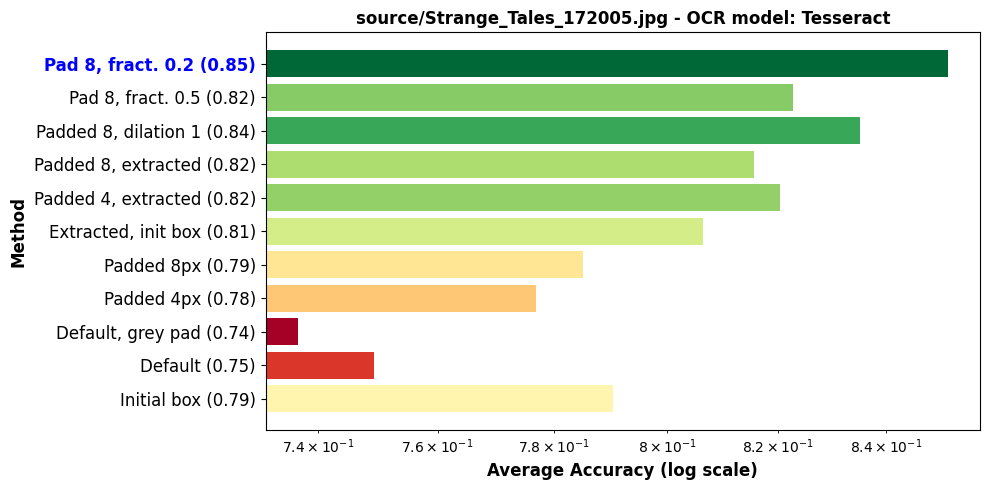

In [ ]:
image_experiment.perform_methods(plot_acc=True)


In [ ]:
image_experiment.display()

---------- Initial box ----------
ResultOCR#block 00: 0.90||Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3
ResultOCR#block 01: 0.93||The house and the old man are alike in many ways; tall, prolid, patient, contented always 0 wait until. their. master cones mome ~~
ResultOCR#block 02: 0.70||“and one in ee would appear.
ResultOCR#block 03: 0.62||Re bambli-~ we have a
ResultOCR#block 04: 0.70||Tonight, he comes noost slamming open the caken
ResultOCR#block 05: 0.82||Tell me naster. how may bambli serve 7
ResultOCR#block 06: 0.56||£7 » and perhaps some dry clothes... 7 /
ResultOCR#block 07: 0.81||The the old man's fades down the hall as... 7
ResultOCR#block 08: 0.85||How curious the 4 fate. whims of had t not chanced to stroll along the river yl tonight ==
ResultOCR#block 09: 0.80||Fas oulckly as t ca, master.
ResultOCR#block 10: 0.91||<the girl would - most slirely be dead by now.
ResultOCR#block 11: 0.47||Ath the girl. a second chance ge a ee yg adil
ResultOCR#block 12: 0.84||Ah girl--there's othing to scream ntt anymore .
ResultOCR#block 13: 0.93||You're among friends now. you're sale
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default ----------
ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~
ResultOCR#block 02: 0.74||And one in ee would appear.
ResultOCR#block 03: 0.41||Rir guest.
ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo
ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _
ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps
ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00
ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >
ResultOCR#block 09: 0.50||Aulckly “master as t can,
ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.
ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee oo tr tt
ResultOCR#block 12: 0.84||Oe girl--there's othing to scream nt anymore. 4
ResultOCR#block 13: 0.96||You're among friends now. youre safe!
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.95||Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their. * master cones home ~-
ResultOCR#block 02: 0.94||“and one in > need of some help, it would appear .
ResultOCR#block 03: 0.88||" bambl-- we have a guest.
ResultOCR#block 04: 0.72||~~and tonight, he comes urgently, slanming open
ResultOCR#block 05: 0.86||Tell me, master: how may bambli serve 7
ResultOCR#block 06: 0.90||Some blankets to keep her. warm, bambli-- and perhaps some dry \ clothes--7 /.
ResultOCR#block 07: 0.06||As.
ResultOCR#block 08: 0.91||How curious the d 7e . whims of fa; had i not chanced to stroll along the river tonight--
ResultOCR#block 09: 0.55||Ickl as t can
ResultOCR#block 10: 0.00||
ResultOCR#block 11: 0.85||Ghede has been generous. the death god has gen + the girl. a second chance te oe ato" pd ate
ResultOCR#block 12: 0.95||Easy, girl--there's | nothing to scream about anyaore.
ResultOCR#block 13: 0.97||You're among friends now. you're safe!
ResultOCR#block 14: 0.54||“continued a

 ---------- Padded 4px ----------
ResultOCR#block 00: 0.88||Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as
ResultOCR#block 01: 0.93||The 

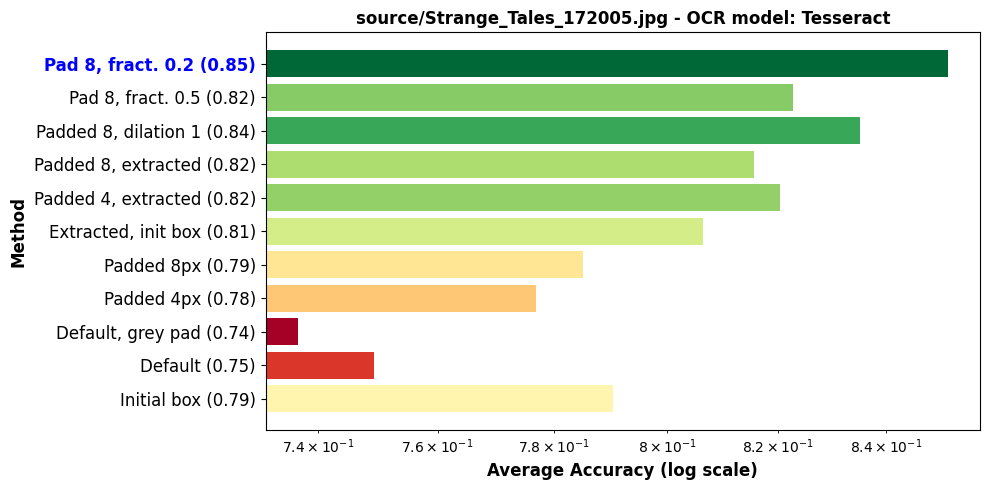

In [ ]:
image_experiment.plot_accuracies()


In [ ]:
RenderJSON(image_experiment.to_dict(), 400, 2)


best results

In [ ]:
ll = image_experiment.best_results()
if ll:
    cprint([(m.value, f"{r.acc:.3f}", r.ocr) for m,r in ll])


[
    (
        'Default, grey pad',
        '0.953',
        'Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of 
new orleans, kept tipy by a white-haired old man known only as'
    ),
    (
        'Padded 8px',
        '0.988',
        'The house and the old man are alike in many ways; tall, proud, patient, contented always to 
wait until their. master comes home'
    ),
    ('Padded 8, dilation 1', '0.968', 'And one in need of some help, it wolld appear .'),
    ('Default, grey pad', '0.880', '" bambl-- we have a guest.'),
    ('Padded 8, dilation 1', '0.794', '=and tonight, he comes most slamming open the front'),
    ('Default, grey pad', '0.857', 'Tell me, master: how may bambli serve 7'),
    (
        'Pad 8, fract. 0.5',
        '0.935',
        'Some blankets to keep her. warm, bambli-~ and perhaps. some dry clothes'
    ),
    ('Initial box', '0.811', "The the old man's fades down the hall as... 7"),
    (
        'Padded 8, extracted',
        '0.959',
        'How curious the whims of fate . had i not chanced to stroll along the river tonight-~'
    ),
    ('Extracted, init box', '0.846', 'Aulckly as t can, master,'),
    ('Extracted, init box', '1.000', '--the girl would most surely be dead by now.'),
    (
        'Padded 8, extracted',
        '0.935',
        'Ghede has been generous. the peath god has given the girl a second chance po'
    ),
    ('Default, grey pad', '0.953', "Easy, girl--there's | nothing to scream about anyaore."),
    ('Default, grey pad', '0.974', "You're among friends now. you're safe!"),
    ('Initial box', '1.000', 'Continued after next page')
]

Perfom experiments given a list of `CropMethod`s


In [ ]:
# methods = [*CropMethod.__members__.values()]
methods = [CropMethod.INITIAL_BOX, CropMethod.DEFAULT]
image_experiment.perform_methods(methods)


Plot the perfomance of the experiments

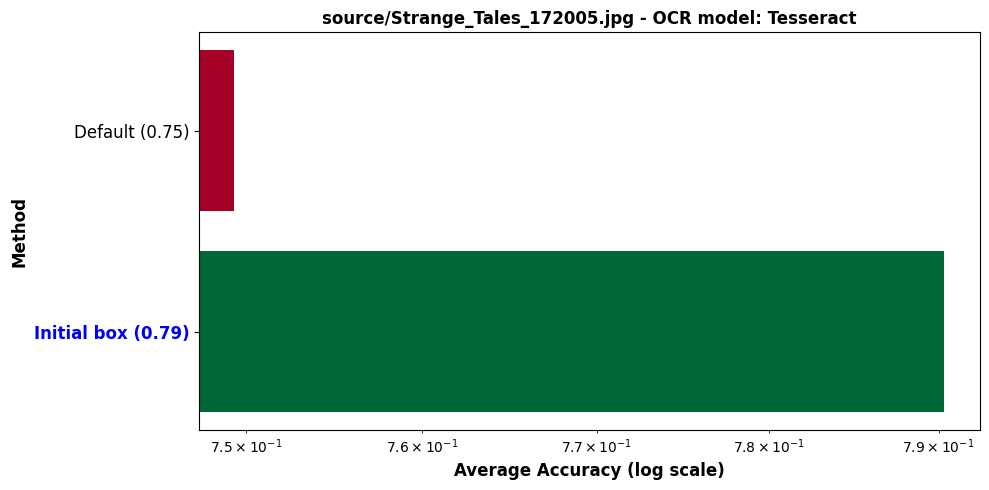

In [ ]:
# image_experiment.plot_accuracies(exps, IMAGE_CONTEXT)
image_experiment.plot_accuracies(methods)


Get experiment for image idx


In [ ]:
saved_exp = ExperimentOCR.from_image(CONTEXT, RUN_NAME, IMAGE_CONTEXT.image_idx)
# saved_exp = ExperimentOCR.saved_experiment(IMAGE_CONTEXT, 'Tesseract', 'Action_Comics_1960-01-00_(262).JPG')
saved_exp.method_experiment(CropMethod.PAD_8_FRACT_0_2).display()


Box #,Image,Accuracy,OCR
1,,0.94,"Enbonered by great snarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as b8ambl ."
2,,0.97,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master comes home ~~"
3,,0.77,And one in ⎕eet⎕⎕⎕ sv⎕e⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.86,Bambl ~~ we have a guest.
5,,0.64,"=~and tonight, he comes ⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕slamming open urg⎕⎕⎕⎕en⎕⎕⎕⎕⎕tly,⎕⎕⎕⎕"
6,,0.82,Tell me⎕ master... how may bambli serve'7
7,,0.94,"Some blankets to keep her, warm, bambli-~ and perhaps. some dry clothes"
8,,0.75,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall ⎕sere
9,,0.96,How curious the whims of fate⎕. had i not chanced to stroll along the river tonight-~
10,,0.81,"A⎕⎕⎕ulckry as t can, master."


Perform experiments for selected boxes y methods

In [ ]:
image_experiment(
    box_idxs=[0, 1, 2, 3],
    methods=[CropMethod.INITIAL_BOX, CropMethod.DEFAULT],
    rebuild=False,
    display=True,
    save_as_ground_truth=False
)


---------- Initial box ----------
ResultOCR#block 00: 0.90||Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3
ResultOCR#block 01: 0.93||The house and the old man are alike in many ways; tall, prolid, patient, contented always 0 wait until. their. master cones mome ~~
ResultOCR#block 02: 0.70||“and one in ee would appear.
ResultOCR#block 03: 0.62||Re bambli-~ we have a
ResultOCR#block 04: 0.70||Tonight, he comes noost slamming open the caken
ResultOCR#block 05: 0.82||Tell me naster. how may bambli serve 7
ResultOCR#block 06: 0.56||£7 » and perhaps some dry clothes... 7 /
ResultOCR#block 07: 0.81||The the old man's fades down the hall as... 7
ResultOCR#block 08: 0.85||How curious the 4 fate. whims of had t not chanced to stroll along the river yl tonight ==
ResultOCR#block 09: 0.80||Fas oulckly as t ca, master.
ResultOCR#block 10: 0.91||<the girl would - most slirely be dead by now.
ResultOCR#block 11: 0.47||Ath the girl. a second chance ge a ee yg adil
ResultOCR#block 12: 0.84||Ah girl--there's othing to scream ntt anymore .
ResultOCR#block 13: 0.93||You're among friends now. you're sale
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default ----------
ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~
ResultOCR#block 02: 0.74||And one in ee would appear.
ResultOCR#block 03: 0.41||Rir guest.
ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo
ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _
ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps
ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00
ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >
ResultOCR#block 09: 0.50||Aulckly “master as t can,
ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.
ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee oo tr tt
ResultOCR#block 12: 0.84||Oe girl--there's othing to scream nt anymore. 4
ResultOCR#block 13: 0.96||You're among friends now. youre safe!
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.95||Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their. * master cones home ~-
ResultOCR#block 02: 0.94||“and one in > need of some help, it would appear .
ResultOCR#block 03: 0.88||" bambl-- we have a guest.
ResultOCR#block 04: 0.72||~~and tonight, he comes urgently, slanming open
ResultOCR#block 05: 0.86||Tell me, master: how may bambli serve 7
ResultOCR#block 06: 0.90||Some blankets to keep her. warm, bambli-- and perhaps some dry \ clothes--7 /.
ResultOCR#block 07: 0.06||As.
ResultOCR#block 08: 0.91||How curious the d 7e . whims of fa; had i not chanced to stroll along the river tonight--
ResultOCR#block 09: 0.55||Ickl as t can
ResultOCR#block 10: 0.00||
ResultOCR#block 11: 0.85||Ghede has been generous. the death god has gen + the girl. a second chance te oe ato" pd ate
ResultOCR#block 12: 0.95||Easy, girl--there's | nothing to scream about anyaore.
ResultOCR#block 13: 0.97||You're among friends now. you're safe!
ResultOCR#block 14: 0.54||“continued a

 ---------- Padded 4px ----------
ResultOCR#block 00: 0.88||Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as
ResultOCR#block 01: 0.93||The 

## On any image

In [ ]:
test_fail(lambda: ExperimentOCR.from_image(CONTEXT, 'Tesseract', 37), 'out of range')


In [ ]:
ImageContextVisor(CONTEXT, 'Action_Comics_1960-01-00_(262).JPG')


In [ ]:
image_action_experiment: ExperimentOCR = cast(ExperimentOCR, ExperimentOCR.from_image(
                            CONTEXT, RUN_NAME, 'Action_Comics_1960-01-00_(262).JPG'))
image_action_experiment.display()


Initial box - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Default - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Default, grey pad - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Padded 4px - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Padded 8px - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Extracted, init box - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Padded 4, extracted - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Padded 8, extracted - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Padded 8, dilation 1 - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Pad 8, fract. 0.5 - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

Pad 8, fract. 0.2 - Tesseract:   0%|          | 0/17 [00:00<?, ?it/s]

---------- Initial box ----------
ResultOCR#block 00: 0.90||Suddenly.
ResultOCR#block 01: 0.81||>gasp!z everything's w- whirling around me!t can't stand sr rea
ResultOCR#block 02: 0.81||Clark!i'm falling' “help! help! —
ResultOCR#block 03: 0.67||I-i'm bs "passing ohhh
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 1.00||Then, seconds later...
ResultOCR#block 06: 0.89||Great caesars ghost! { this /s black magic! we've been transportel to the weirdest world, tit ever saw!
ResultOCR#block 07: 0.91||...|t certainly isn't our earth, perry. look at the size of those bees.
ResultOCR#block 08: 0.88||Watch out, clark!
ResultOCR#block 09: 0.73||Owwww.
ResultOCR#block 10: 0.85||Yet the bee's stinger went ws. right through my uniform and penetrated my skin! that means. the fabric of pe ay costume has become dj} satie fued 1,
ResultOCR#block 11: 0.87||Hurry. let's beat it before we get stung, foo = aii
ResultOCR#block 12: 0.86||Ggreat guns!...2g, .pa/n i feel n pain! as superman, i should be > invulnerable! 1 have unbreakabl ‘skin! under my clark kent clothes, im wearing an woestructisle superman uniform ! =
ResultOCR#block 13: 1.00||Abruptly...
ResultOCR#block 14: 0.77||Great caesar's ghost. he's spinning a web of g/ant, sr strands --
ResultOCR#block 15: 0.89||I-i feel the heat of the sun...the pain of the bee-sting ... the heavy weight of my pack! every human discomfort... good grief! i've lost all my super-powers! i've become an ordinary mortal in this world. /
ResultOCR#block 16: 0.84||Enormous spider- like creature is going berserk, as if the sight of us excited him (into mad spinning get back! that 2

 ---------- Default ----------
ResultOCR#block 00: 1.00||Suddenly...
ResultOCR#block 01: 0.80||Gasp! everything's w- whi rns atound me!i can't stand we a
ResultOCR#block 02: 0.87||Clark!i'm falling! help! help
ResultOCR#block 03: 0.45||I-i'm se ou
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 0.95||Then, seconds later.
ResultOCR#block 06: 0.92||Great caesar's ghost! this /s black magic! we've been transported, to the weirdest world, i ever saw!
ResultOCR#block 07: 0.93||...|t certainly isn't our earth, perry look at the size of those bees!
ResultOCR#block 08: 0.88||Watch out, clark)
ResultOCR#block 09: 0.67||Owwww.,
ResultOCR#block 10: 0.97||Yet the bee's stinger went = right through my uniform ando penetrated my skin! that mean the fabric of my superman costume has become ordinary, cloth! £
ResultOCR#block 11: 0.89||Hurry. let's beat it before we get stung, tod yi
ResultOCR#block 12: 0.88||Ggreat guns!...2gasp/z...pain i feel n fan! as superman, i should be invulnerable! 1 have unbreakable skin! under my clark kent clothes, i'm wearing an /noestruct/ele superman uniform !
ResultOCR#block 13: 1.00||Abruptly...
ResultOCR#block 14: 0.76||Great caesars ° ghost! he's spinning & web of g/a, silk strands
ResultOCR#block 15: 0.89||I-i feel the heat of the sum...the pain of the bee-sting... the heavy weight of my { pack! every human discomfort... good grief! i've lost all my super -powersx ve become an ordinary mortal in this world! j
ResultOCR#block 16: 0.70||Like creature is going berserk, as if the sight of us excited him into mad spinning, get back! that \ enormous spider-

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.78||Sudden.
ResultOCR#block 01: 0.82||5gasp!z everything's | w- whirling around] me!t can't stand ue a
ResultOCR#block 02: 0.57||Ark!i'm falling
ResultOCR#block 03: 0.85||I-t'm eq "passing out... ohhh.
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 0.00||
ResultOCR#block 06: 0.88||‘great caesar's ghost! || this /§ black magic! we've been transportel to the weirdest world, i ever saw.
ResultOCR#block 07: 0.87||"...it certainly isn't our | earth, perry look at the| \s|ze of those bees.
ResultOCR#block 08: 0.88||Watch out, clark!
ResultOCR#block 09: 0.73||Owwww.
ResultOCR#block 10: 0.90||Yet the bee's stinger went ~ right through my uniform and penetrated my skin! that mea

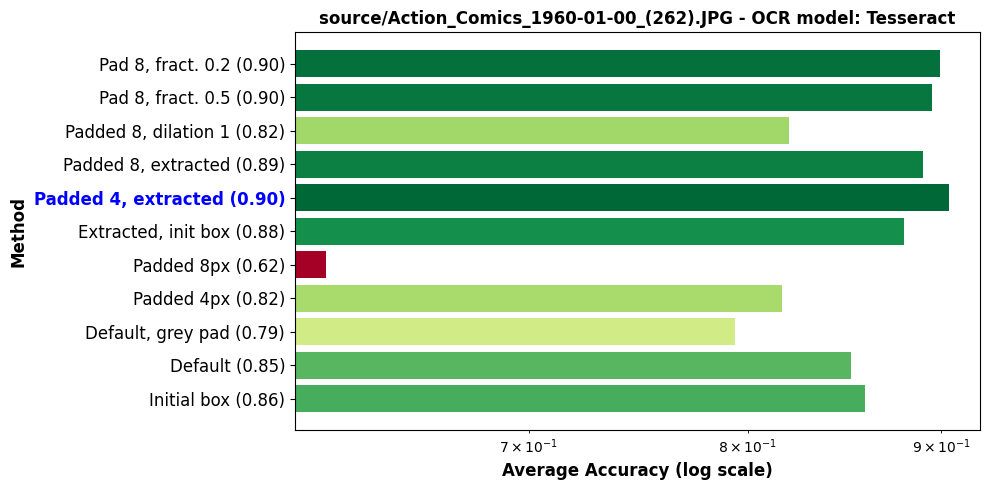

In [ ]:
image_action_experiment.plot_accuracies()


In [ ]:
image_action_experiment.result(14, CropMethod.PADDED_4)


,"Great caesars ghost. he's spinning a web of g/ant, | silk strands as tough as steel!0.91"


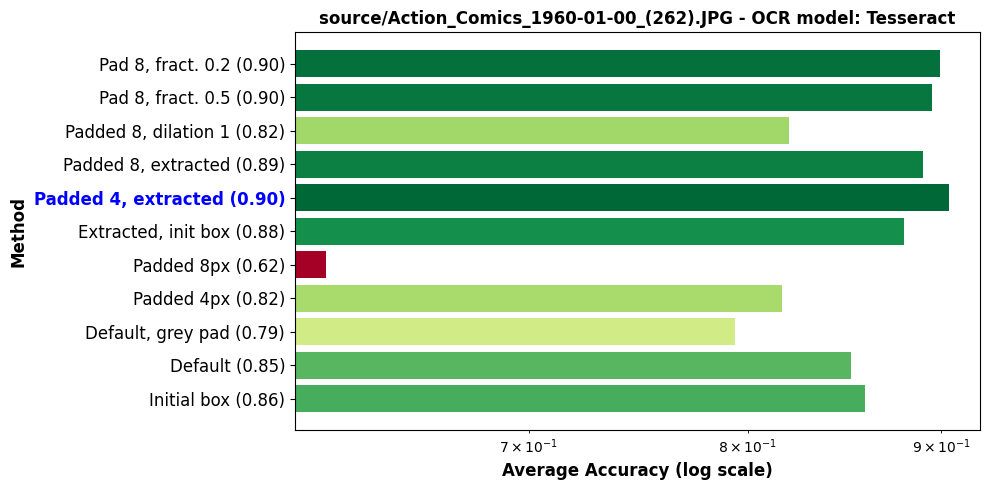

In [ ]:
image_action_experiment.perform_methods(plot_acc=True)


# Everything Everywhere All at Once


## ExperimentsVisor

In [ ]:
#| export

class ExperimentsVisor(ContextVisor):
    ctx: OCRExperimentContext

    def update_output(self, 
            run_name: RunIdT | None = None,
            image_idx: ImgIdT | None = None,
            display_option: DisplayOptions | None = None, 
            msg: str | None = None,
            **kwargs):
        (run_selector, image_selector, content_selector, 
            result_visor, _, message_visor) = self._comps()
        if msg is not None and msg != MessageVisor.EMPTY:
            message_visor.update_output(msg=msg)
        if run_name is not None:
            run = OCRExperimentRun(run_selector.ctx, run_name)
            exp_ctx = result_visor.ctx
            exp_ctx.run = run
            result_visor.ctx = exp_ctx
        if image_idx is not None:
            img_ctx = ImageContext(self.ctx, image_idx)
            result_visor.ctx.ctx = img_ctx
            display_option = content_selector.values['display_option']
        if display_option is not None and display_option != DisplayOptions.RESULTS:
            result_visor.hide()
            if display_option == DisplayOptions.BEST_RESULTS:
                result_visor.best_results()
            elif display_option == DisplayOptions.ACCURACY:
                result_visor.ctx.plot_accuracies()
            elif display_option == DisplayOptions.DATAFRAME:
                result_visor.pd_to_html()
            else:
                content_selector.display_content(image_selector.image_ctx, display_option)
        else:
            result_visor.show()
            result_visor.update_output(**kwargs)


    @property
    def status_visor(self) -> StatusVisor: return cast(StatusVisor, self.comps['status_visor'])
    @property
    def message_visor(self) -> MessageVisor: return cast(MessageVisor, self.comps['message_visor'])
    @property
    def image_context(self) -> ImageContext: 
        return ImageContext(self.ctx, self.comps['image_selector'].values['image_idx'])
    @property
    def run_name(self) -> str: return cast(str, self.comps['run_selector'].values['run_name'])
    @property
    def image_experiment(self) -> ExperimentOCR: return ExperimentOCR(self.image_context, self.run_name)

    def _comps(self):
        cc = self.comps
        rsel: RunSelector = cc['run_selector']  # type: ignore
        isel: ImageSelector = cc['image_selector']  # type: ignore
        cs: ContentSelector = cc['content_selector']  # type: ignore
        rv: ResultVisor = cc['result_visor']  # type: ignore
        sv: StatusVisor = cc['status_visor']  # type: ignore
        mv: MessageVisor = cc['message_visor']  # type: ignore
        return rsel, isel, cs, rv, sv, mv

    def setup_ui(self):
        ctls = self.controls.values()
        rselw, iselw, csw, rvw, svw, _ = [_.w for _ in self._comps()]
        return W.VBox([W.HBox([rselw, iselw, csw, svw, *ctls]), rvw])

    def save(self, b):
        ctx = self.ctx
        fp = ctx.save()
        self.update(msg=f"'{ctx.name}' experiment saved on {fp}")

    def reset(self, b): 
        image_idx = self.comps['image_selector'].values['image_idx']
        self.ctx.reset_results(image_idx=image_idx)

    def setup_ux(self):
        self.status_visor.save_button.on_click(self.save)
        self.status_visor.reset_button.on_click(self.reset)

    def setup_experiment_context(self, 
            ocr_model: str | None = None,
            root_dir: Path | str | None = None, 
            config: cfg.Config | None = None, 
            run_names: list[str] | None = None,
        ):
        ctx = OCRExperimentContext(ocr_model or 'Tesseract', root_dir, config=config)  # type: ignore
                    
        for run_name in run_names or ['Tesseract-crop-post', 'Tesseract-crop']:
            OCRExperimentRun(ctx, run_name)
        return ctx

    def __init__(self, 
            ctx: OCRExperimentContext | None = None, 
            ocr_model: str | None = None,
            root_dir: Path | str | None = None, 
            config: cfg.Config | None = None, 
            image_idx: ImgIdT | str | Path = 0,
            run_name: str | None = None, 
            run_names: list[str] | None = None,
            display_option: DisplayOptions = DisplayOptions.RESULTS,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            # ocr_model: OCRModel = OCRModel.TESSERACT,
            # ocr_models: dict[str, OCRModel] = {'Tesseract': OCRModel.TESSERACT},
            out: W.Output | None = None,
        ):
        if ctx is None:
            ctx = self.setup_experiment_context(ocr_model, root_dir, config, run_names)
        _ = ImageContext(ctx, image_idx)  # raises if image_idx is out of range
        
        out = out or self.out
        run_selector = RunSelector(ctx, run_name, run_names, out=out)
        exp = ExperimentOCR.from_image(ctx, run_selector.values['run_name'], image_idx)
        image_selector = ImageSelector(ctx, image_idx=image_idx, out=out)
        content_selector = ContentSelector(ctx, display_option=display_option, out=out)
        result_visor = ResultVisor(exp, out=out,
            all_boxes=all_boxes, box_idx=box_idx, all_methods=all_methods, method=method,
            ctxs={'spinner': Spinner(ctx, 20, 3)}
            )
        status_visor = StatusVisor(ctx, out=None)
        message_visor = MessageVisor(MessageVisor.EMPTY, out=out)
        
        super().__init__(ctx, {}, out=out, 
                    ctxs={'run_selector': run_selector, #'model_selector': model_selector, 
                        'image_selector': image_selector, 'content_selector': content_selector, 
                        'result_visor': result_visor, 
                        'status_visor': status_visor, 
                        'message_visor': message_visor,
                        },
                    )


## Visualize all

In [ ]:
cleanupwidgets('experiments_visor')

tesseract_experiment = ExperimentsVisor(image_idx=BASE_IMAGE_IDX)
tesseract_experiment.display()

test_eq(tesseract_experiment.all_values, {
    'run_selector': {'run_name': 'Tesseract-crop-post'},
    'image_selector': {'image_idx': BASE_IMAGE_IDX},
    'content_selector': {'display_option': DisplayOptions.RESULTS},
    'result_visor': {
        'all_boxes': False,
        'box_idx': 0,
        'all_methods': False,
        'method': CropMethod.INITIAL_BOX,
    },
    # 'status_visor': {'dirty': True},
    'status_visor': {},
    'message_visor': {'msg': MessageVisor.EMPTY},
    'self': {}
})


In [ ]:
# image_ctx = tesseract_experiment.image_context
# image_ctx.setup_ground_truth()
# image_ctx.gts()


In [ ]:
# image_experiment = tesseract_experiment.image_experiment
# image_experiment.save_results_as_ground_truth()



In [ ]:
tesseract_experiment.all_controls['box_idx'].value += 1


In [ ]:
tesseract_experiment.status_visor.save_button.click()


In [ ]:
tesseract_experiment.update(display_option=DisplayOptions.BOXES)


In [ ]:
tesseract_experiment.all_controls['image_idx'].value = 1

# Colophon
----


In [ ]:
import fastcore.all as FC
from nbdev.export import nb_export


In [ ]:
if FC.IN_NOTEBOOK:
    nb_export('experiments.ipynb', '../testbed')
